# A continuación se encuentra el código utilizado para el trabajo práctico que tiene como objetivo realizar un análisis descriptivo y exploratorio de un dataset que contiene información climática de Australia brindado por la cátedra, junto con la implementación de un modelo para la predicción de la variable "RainTomorrow" que indica si el día siguiente lloverá o no.

## Librerías a utilizar durante el trabajo

In [ ]:
!pip install --force-reinstall -v "numpy == 1.26.4"
!pip install --force-reinstall -v "scikit-learn == 1.5.0"
!pip install pycaret
!pip install shap
!pip install optuna

In [83]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Mathematical operations
from math import sqrt, sin, cos, pi
import random

# Preprocessing
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import KNNImputer

# Model training and evaluation
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, roc_curve, auc, classification_report, 
    matthews_corrcoef, cohen_kappa_score
)

# Oversampling
from imblearn.over_sampling import RandomOverSampler

# Advanced libraries
import shap
import optuna

# PyTorch
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

# PyCaret
from pycaret.classification import *

# Device selection for PyTorch
device = "cuda" if torch.cuda.is_available() else "cpu"

## Consigna 1

In [84]:
df = pd.read_csv('weatherAUS.csv')

Descripción de las variables a utilizar en el trabajo práctico y rango de variación de las mismas:

*   Date: Fecha de la observación meteorológica.
*   Location: Nombre o código de la estación meteorológica.
*   MinTemp: Temperatura mínima registrada en grados Celsius (-8, 30.3).
*   MaxTemp: Temperatura máxima registrada en grados Celsius (4.1, 46.9).
*   Rainfall: Cantidad de lluvia registrada en milímetros (0, 192).
*   Evaporation: Evaporación de agua en milímetros (0, 86.2).
*   Sunshine: Se registraron horas de sol brillante (0, 14.3).
*   WindGustDir: Dirección de la ráfaga de viento según sistema de coordenadas geográficas (W,SSE).
*   WindGustSpeed: Velocidad máxima de la ráfaga de viento en kilómetros por hora (7, 126).
*   WindDir9am: Dirección de la ráfaga de viento a las 9 am (W,SSE).
*   WindDir3pm: Dirección de la ráfaga de viento a las 3 pm (E,NW).
*   WindSpeed9am: Velocidad del viento a las 9 am en kilómetros por hora (0, 87).
*   WindSpeed3pm: Velocidad del viento a las 3 pm en kilómetros por hora (0, 72).
*   Humidity9am: Humedad relativa a las 9 am en porcentaje (1, 100).
*   Humidity3pm: Humedad relativa a las 3 pm en porcentaje (1, 100).
*   Pressure9am: Presión atmosférica a las 9 am en hPa (986.2, 1040.6).
*   Pressure3pm: Presión atmosférica a las 3 pm en hPa (982.6, 1037.9).
*   Cloud9am: Nubosidad a las 9 am en octavas (0, 9).
*   Cloud3pm: Nubosidad a las 3 p.m. en octavas (0, 8).
*   Temp9am: Temperatura a las 9 am en grados Celsius (-1.3, 39.4).
*   Temp3pm: Temperatura a las 3 pm en grados Celsius (3.7, 46.2).
*   RainToday: Variable binaria que indica si llovió hoy (1 para "Sí", 0 para "No").

Nuestra variable de salida o target será 'RainTomorrow'

*   RainTomorrow: variable de destino binaria que indica si lloverá mañana (1 para "Sí", 0 para "No").


In [85]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [86]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [87]:
df.groupby('Location').count()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
Location,,,,,,,,,,,,,,,,,,,,,
Adelaide,3193,3191,3190,3091,1704,1769,3167,3167,2919,3177,...,3188,3188,3185,3186,0,0,3188,3189,3091,3090
Albany,3040,2977,2986,3016,2750,2520,0,0,2793,2257,...,2991,2324,3015,3015,3002,2329,3001,2328,3016,3016
Albury,3040,3029,3029,3011,0,0,3008,3008,2515,2994,...,3031,3032,3035,3032,1289,1427,3031,3032,3011,3011
AliceSprings,3040,3039,3038,3032,2825,2520,2989,2989,2810,3036,...,3037,3035,3039,3037,2706,2679,3040,3038,3032,3031
BadgerysCreek,3009,2973,2980,2928,0,0,2933,2933,2574,2924,...,2955,2954,2841,2836,0,0,2968,2965,2928,2928
Ballarat,3040,3039,3039,3028,0,0,3009,3009,2949,3022,...,3019,3033,3016,3014,2494,1992,3028,3034,3028,3028
Bendigo,3040,3038,3035,3034,1185,0,2999,3000,2796,2997,...,3033,3038,3025,3030,2072,2268,3037,3038,3034,3034
Brisbane,3193,3184,3179,3161,3174,3144,3152,3152,3123,3159,...,3189,3178,3192,3185,3192,3191,3189,3178,3161,3161
Cairns,3040,3039,3040,2988,2670,2564,3021,3022,2997,3036,...,3039,3040,3039,3040,2833,2810,3039,3040,2988,2988


In [88]:
df[df['Location'] == 'MountGini']['Location'] = 'MountGinini'           # Posibles errores de tipeo

lista = list(df['Location'].unique())                                   # Lista de ciudades

random.seed(147855)

selected_locations = random.sample(list(df['Location'].unique()), 10)   # Selección de 10 ciudades al azar

selected_locations

['Melbourne',
 'Sydney',
 'Albany',
 'WaggaWagga',
 'Albury',
 'CoffsHarbour',
 'Perth',
 'Canberra',
 'NorfolkIsland',
 'Moree']

In [89]:
df = df[df['Location'].isin(selected_locations)]    # Filtrado del df para las 10 ciudades seleccionadas

df = df.dropna(subset=['RainTomorrow'])                         # Eliminamos registros sin target, 1125 de 31282 (3.6%)

df.drop(df[df.isnull().sum(axis=1) > 11].index, inplace=True)   # Registros donde haya mas de 12 nulls 819 de 31282 (2.6%)

df.isna().sum()                                                 # Nan restantes por columna

Date                0
Location            0
MinTemp            41
MaxTemp            41
Rainfall          288
Evaporation      6808
Sunshine         8235
WindGustDir      4587
WindGustSpeed    4583
WindDir9am       1800
WindDir3pm       1136
WindSpeed9am      335
WindSpeed3pm      983
Humidity9am       118
Humidity3pm       728
Pressure9am       296
Pressure3pm       292
Cloud9am         5041
Cloud3pm         5608
Temp9am            33
Temp3pm           687
RainToday         288
RainTomorrow        0
dtype: int64

In [90]:
df['RainTomorrow'] = df['RainTomorrow'].apply(lambda x: 1 if x == 'Yes' else 0)     # Codificamos target a 0 / 1

df['RainToday'] = df['RainToday'].apply(lambda x: 1 if x == 'Yes' else 0)           # Misma codificación para RainToday

df['Date'] = pd.to_datetime(df['Date'])                                             # Conversión de tipo de dato a datetime

df.loc[:, 'week'] = df['Date'].dt.isocalendar().week                                # Creamos una columna de semana para las fechas

df.loc[:, 'week'] = df['week'].astype(float) / 53.0                             # Normalización de 'week' (53 máximo de semanas que existen)

df.loc[:, 'sin_week'] = df['week'].apply(lambda x: sin(2 * pi * x))             # Creamos las columnas seno y coseno             
df.loc[:, 'cos_week'] = df['week'].apply(lambda x: cos(2 * pi * x))             # Evitando discontinuidades ya que la última y primer semana del año quedan "cerca"

df.drop('week', axis=1, inplace=True)                                           # Eliminamos la columna 'week' original 

directions = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']   # Lista de direcciones posibles del viento

df['WindGustDir'] = df['WindGustDir'].apply(lambda x: directions.index(x) if x in directions else None)

df['WindGustDir_cos'] = df['WindGustDir'].apply(lambda x: cos(2 * pi * x / 16) if x is not None else None)          # Misma codificación que para semana
df['WindGustDir_sin'] = df['WindGustDir'].apply(lambda x: sin(2 * pi * x / 16) if x is not None else None)          # Capturaoms mejor relaciones cíclicas

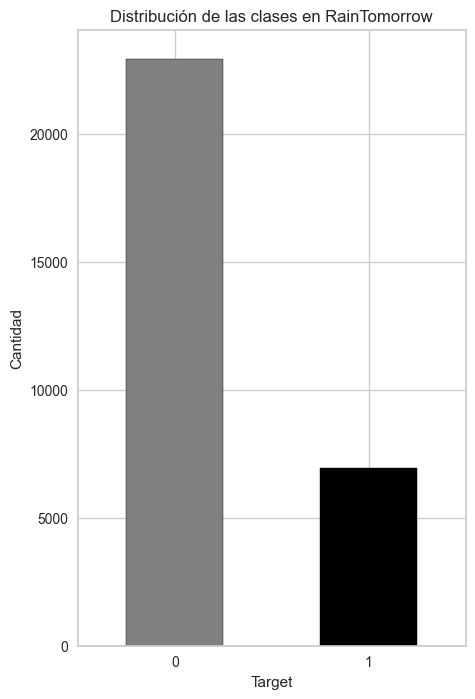

In [91]:
target_counts = df['RainTomorrow'].value_counts()

plt.figure(figsize=(5, 8))
target_counts.plot(kind='bar', color=['gray', 'black'], edgecolor='black')
plt.title('Distribución de las clases en RainTomorrow')
plt.xlabel('Target')
plt.ylabel('Cantidad')
plt.xticks(rotation=0)
plt.show()

In [92]:
y = df['RainTomorrow']
X = df.drop(columns = ['RainTomorrow'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)         # División entrenamiento/testeo 80/20 estratificando por target

ros = RandomOverSampler(random_state=0)                                                                         # Balanceamos con RandomOverSampler (duplica clase minoritaria)

X_train, y_train = ros.fit_resample(X_train, y_train)                                                           # Balanceamos solo en entrenamiento para evitar fugas de datos

print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de y_train: {y_train.shape}")
print(f"Forma de X_test: {X_test.shape}")
print(f"Forma de y_test: {y_test.shape}")

Forma de X_train: (36688, 26)
Forma de y_train: (36688,)
Forma de X_test: (5976, 26)
Forma de y_test: (5976,)


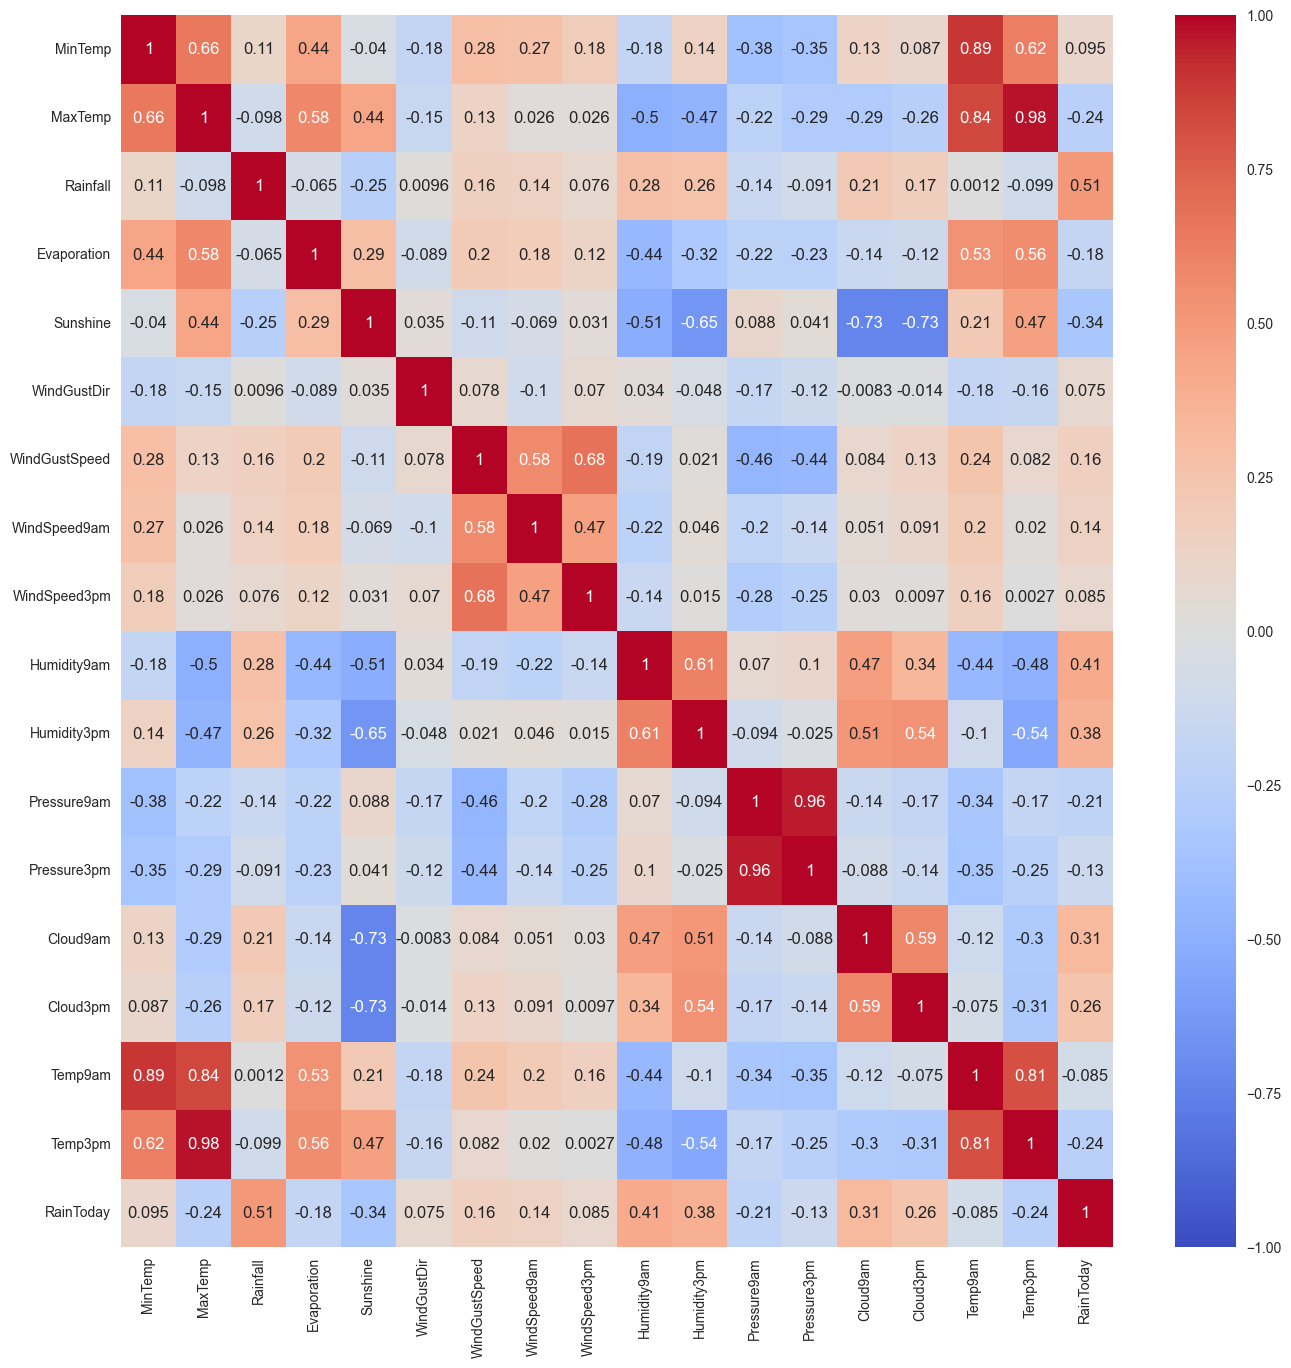

In [93]:
X_train_num = X_train.select_dtypes(include=['int64', 'float64'])                                               # Tomamos todas las variables numericas
X_train_num = X_train_num.drop(columns = ['sin_week', 'cos_week', 'WindGustDir_cos', 'WindGustDir_sin'])        # Sacamos codificadas

plt.figure(figsize=(16, 16))
sns.heatmap(X_train_num.corr(), annot=True, cmap='coolwarm', vmin = -1, vmax = 1)
plt.show()

Temp 9am y 3pm es correlacionado casi perfecto  con min y max temp respectivamente. Por lo que vamos a eliminar alguna de estas.

Ademas, Sunshine este altamente correlacionado negativamente con humidity y cloud tanto 9am como 3pm. Pero tiene mas nulls que las anteriores por lo que tambien dropeo esta fila a pesar de la buena correlacion que tiene con la variable respuesta

(La colinealidad de las variables afecta el modelo lineal)

Ademas, windspeed tanto 9am como 3pm no pareciera tener una correlacion grande por lo que tambien se eliminara

In [94]:
X_test = X_test.drop(['Temp3pm', 'Temp9am', 'Sunshine', 'WindSpeed9am', 'WindSpeed3pm', 'WindDir9am', 'WindDir3pm', 'Pressure9am'], axis=1)     # Eliminación de variables con fuertes correlacione analizadas anteriormente
X_train = X_train.drop(['Temp3pm', 'Temp9am', 'Sunshine', 'WindSpeed9am', 'WindSpeed3pm','WindDir9am', 'WindDir3pm', 'Pressure9am'], axis=1)

X_train_num = X_train.select_dtypes(include=['int64', 'float64'])                                                                               # Seleccionamos nuevamente las numéricas del conjunto restante para visuaulizaciones
X_train_num = X_train_num.drop(columns = ['sin_week', 'cos_week', 'WindGustDir_cos', 'WindGustDir_sin'])

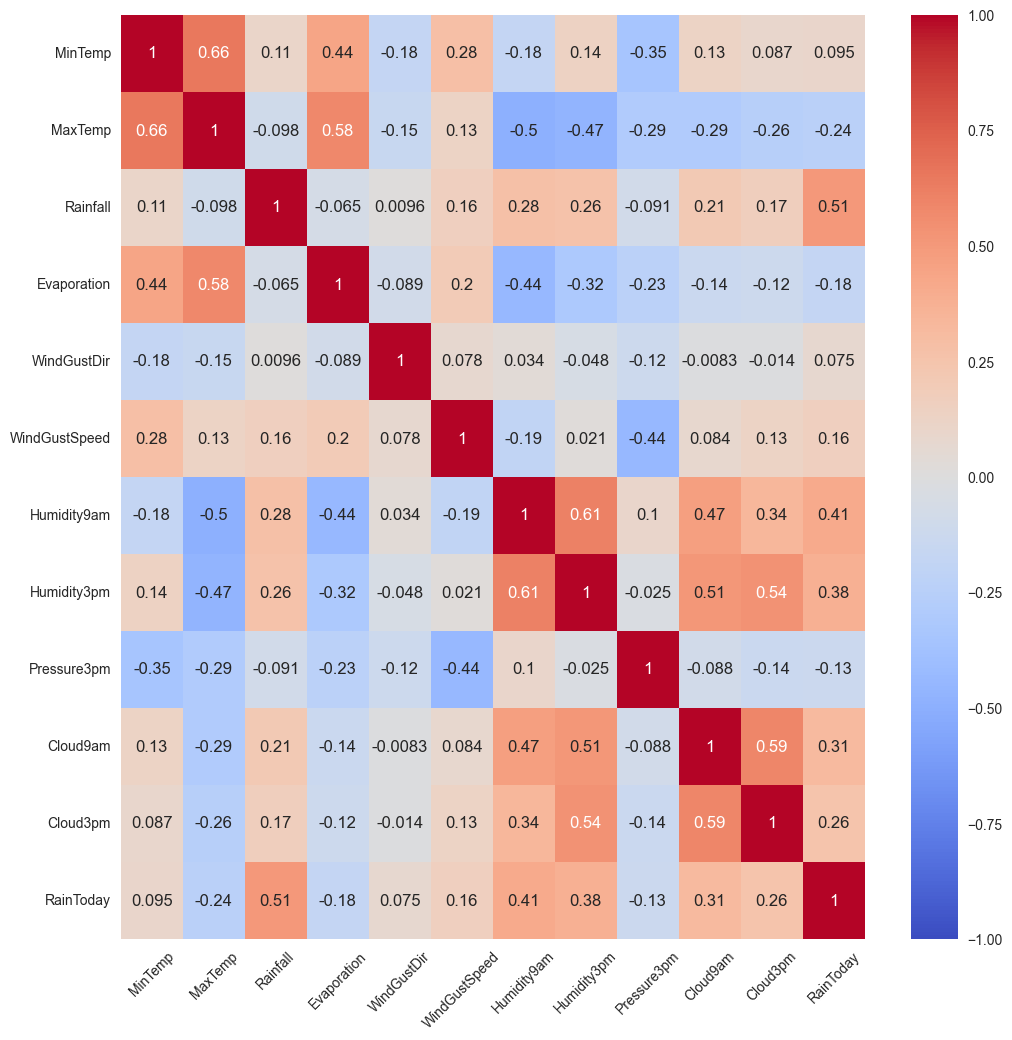

In [95]:
plt.figure(figsize=(12, 12))
sns.heatmap(X_train_num.corr(), annot=True, cmap='coolwarm', vmin = -1, vmax = 1)           # Creamos un heatmap con la correlacion de las variables restantes
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.show()

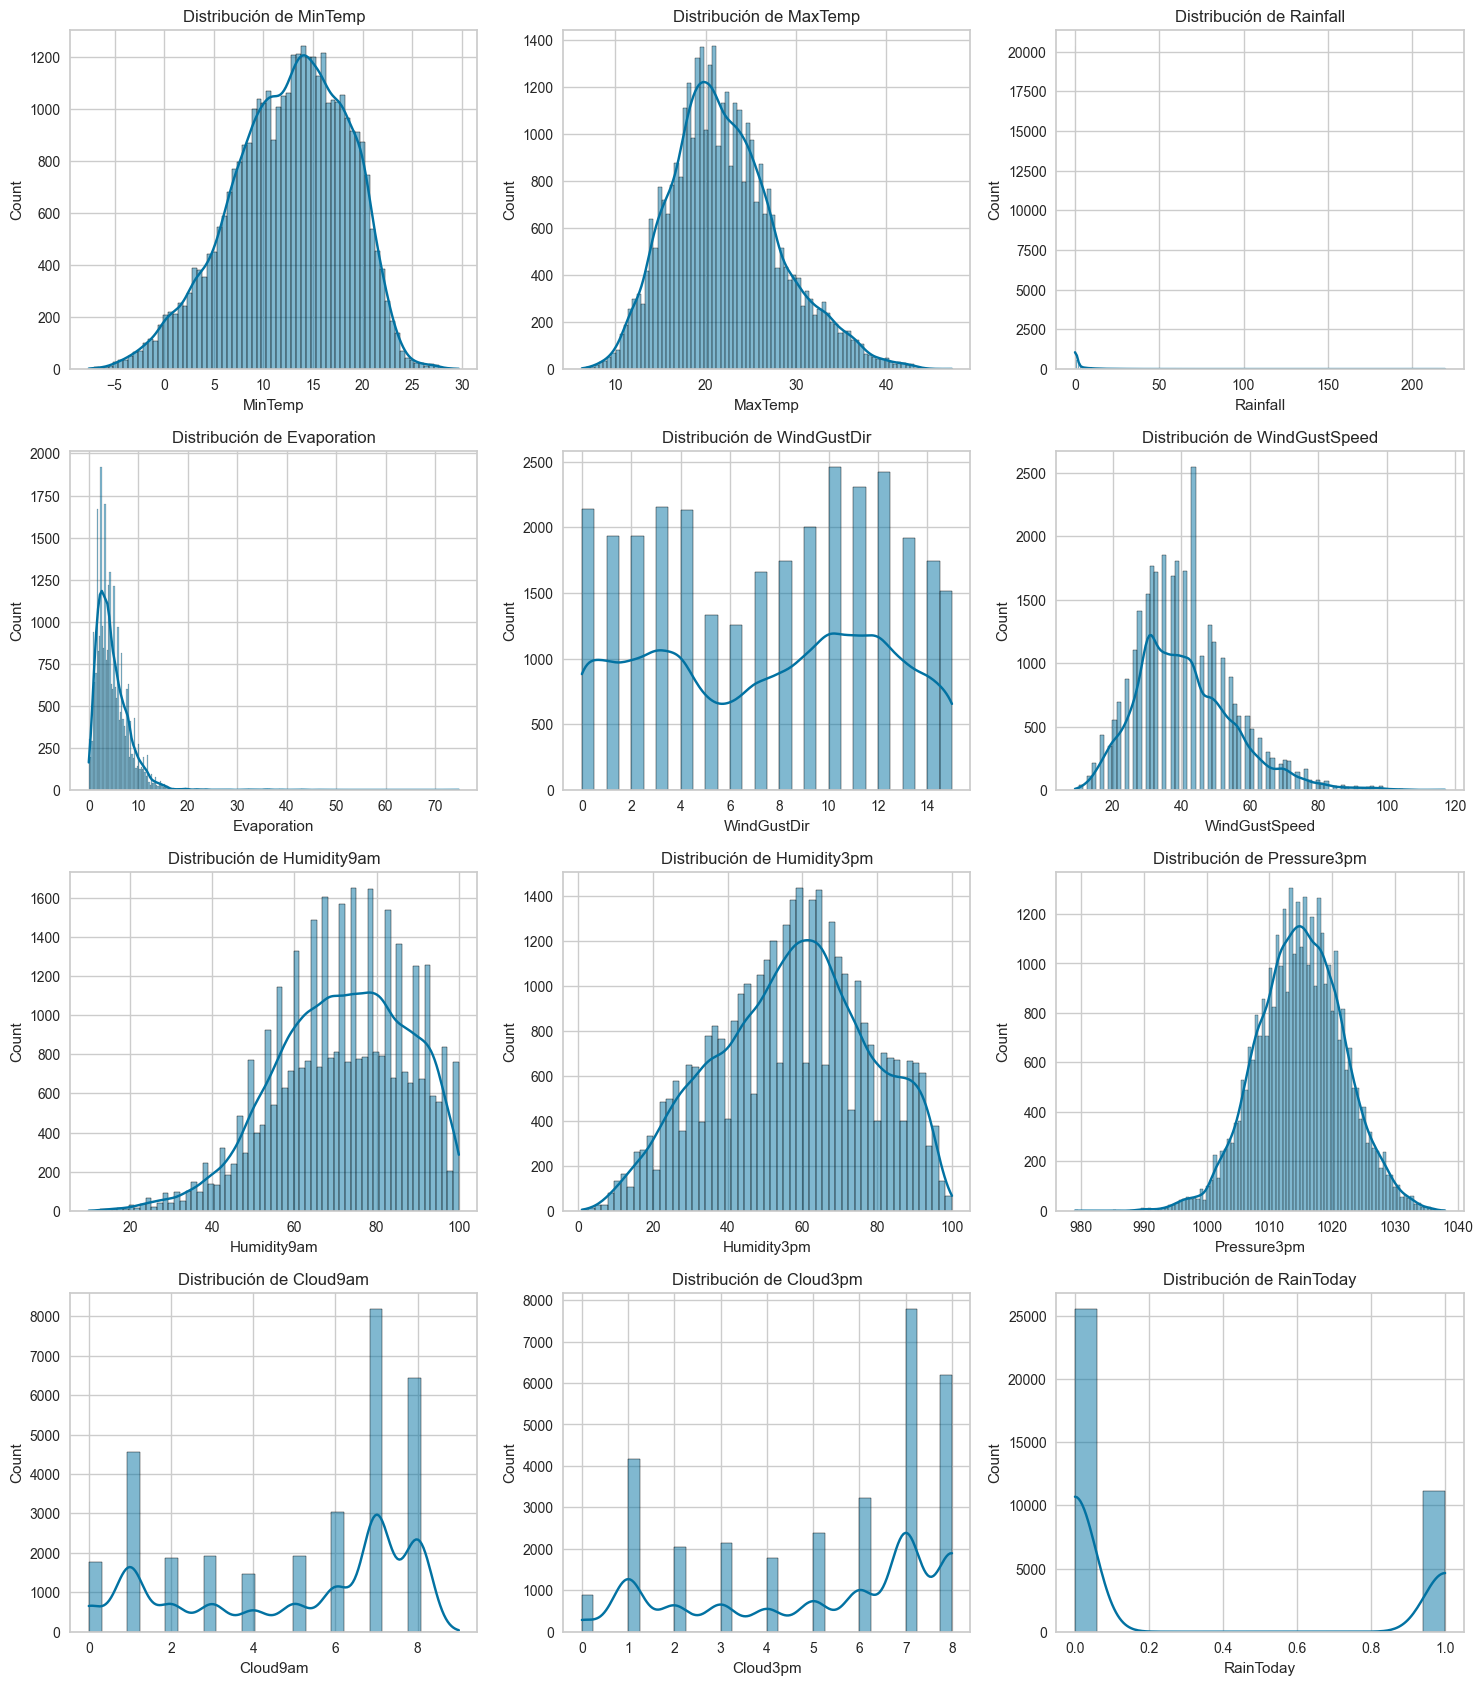

In [96]:
fig, axes = plt.subplots(6, 3, figsize=(15, 25)) 

axes = axes.flatten() 

for i, col in enumerate(X_train_num.columns):
    sns.histplot(X_train_num[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribución de {col}')

for j in range(len(X_train_num.columns), 6 * 3):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Parece que 2 variables (rainfall y evaporation) tienen 2 distribuciones muy asimetricas, capaz se podria transformar.

In [97]:
media = y_train.mean()
sd = sqrt((media * (1 - media)) / len(y_train))

train = pd.concat([X_train, y_train], axis=1)

train.groupby('Cloud9am')['RainTomorrow'].mean()         # Notamos que cloud9am y 3pm aunque sean variables categóricas son ordinales, esto quiere decir que 8 signfica que hay mas nubes que en 7

Cloud9am
0.0    0.101079
1.0    0.245826
2.0    0.381993
3.0    0.431854
4.0    0.503415
5.0    0.499215
6.0    0.571429
7.0    0.635298
8.0    0.736491
9.0    0.000000
Name: RainTomorrow, dtype: float64

In [98]:
X_train.loc[X_train['Cloud9am'] == 9.0, 'Cloud9am'] = 0     
X_test.loc[X_test['Cloud9am'] == 9.0, 'Cloud9am'] = 0       # Ya que hay solo 2 observaciones con nivel 9, lo trataremos como datos mal imputados (la probabilidad de lluvia aumenta conforme es mas grande)


print(X_train[X_train['Cloud9am'].isnull() & X_train['Cloud3pm'].isnull()].shape)                           # suma de filas con cloud9am y pm nulls
X_train[X_train['Cloud9am'].isnull() & X_train['Cloud3pm'].isnull() & X_train['RainToday'].isnull()].shape

(4035, 18)


(0, 18)

In [99]:
def impute_cloud_toapply(row):                                                      # Definimos una función para imputar las variables Cloud9am y Cloud3pm
    if pd.isnull(row['Cloud9am']) and pd.isnull(row['Cloud3pm']):                   # En caso de no tener registros para ninguna
        row['Cloud9am'] = 1 if row['RainToday'] == 0 else 7                         # Si hoy no llovió, entonces 1 sino 7
        row['Cloud3pm'] = 1 if row['RainToday'] == 0 else 7
    elif pd.isnull(row['Cloud9am']):                                                # En caso de faltar solo una de 2, imputamos con la restante
        row['Cloud9am'] = row['Cloud3pm']
    else:
        row['Cloud3pm'] = row['Cloud9am']
    return row

X_train.apply(impute_cloud_toapply, axis=1)
X_test.apply(impute_cloud_toapply, axis=1)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,WindGustDir,WindGustSpeed,Humidity9am,Humidity3pm,Pressure3pm,Cloud9am,Cloud3pm,RainToday,sin_week,cos_week,WindGustDir_cos,WindGustDir_sin
12572,2010-05-21,Moree,10.3,22.3,0.0,3.0,9.0,26.0,64.0,33.0,1015.2,8.0,8.0,0,0.696551,-0.717507,-0.923880,-0.382683
30862,2009-12-18,Sydney,20.2,21.4,5.4,13.6,NaN,NaN,87.0,83.0,1016.7,8.0,8.0,1,-0.234886,0.972023,NaN,NaN
1575,2013-06-22,Albury,-1.3,13.9,0.0,NaN,7.0,15.0,87.0,53.0,1024.8,1.0,1.0,0,0.176890,-0.984231,-0.923880,0.382683
31420,2011-07-29,Sydney,7.3,20.0,0.0,3.6,13.0,22.0,75.0,32.0,1023.6,1.0,1.0,0,-0.403123,-0.915146,0.382683,-0.923880
110477,2014-05-19,Albany,12.7,20.0,12.2,2.0,NaN,NaN,97.0,77.0,1015.4,2.0,2.0,1,0.606800,-0.794854,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48916,2017-03-11,Canberra,9.1,30.1,0.0,NaN,14.0,31.0,94.0,28.0,1010.0,1.0,1.0,0,0.926690,0.375828,0.707107,-0.707107
9344,2009-10-14,CoffsHarbour,13.3,28.5,0.0,8.0,14.0,69.0,27.0,13.0,1001.1,0.0,0.0,0,-0.964636,0.263587,0.707107,-0.707107
9519,2010-04-07,CoffsHarbour,19.7,25.0,0.0,2.2,0.0,41.0,67.0,60.0,1016.3,8.0,8.0,0,0.996050,-0.088796,1.000000,0.000000
2924,2017-03-02,Albury,17.7,34.5,0.0,NaN,6.0,35.0,58.0,31.0,1014.5,1.0,1.0,0,0.875735,0.482792,-0.707107,0.707107


In [100]:
X_train = X_train.drop(['Date', 'Location', 'WindGustDir'], axis=1) # Dropeamos Date Location y Windgust
X_test = X_test.drop(['Date', 'Location', 'WindGustDir'], axis=1)

X_train_num = X_train.select_dtypes(include=['int64', 'float64'])   # Seleccionamos numéricas de conjunto restante

In [101]:
cols = X_train_num.columns

cols = cols.drop(labels = ['RainToday', 'Cloud9am', 'Cloud3pm', 'sin_week', 'cos_week', 'WindGustDir_cos', 'WindGustDir_sin']) # Cloud9am y 3pm es ordinal y tienen relacion lineal con la variable respuesta, por lo que quedan así

scaler = PowerTransformer()                                     # Normalizamos con PowerScaler las columnas numericas
X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols] = scaler.transform(X_test[cols])

X_train['Cloud9am'] = X_train['Cloud9am'] / 8                   # Escalamos entre 0 y 1 Cloud
X_test['Cloud9am'] = X_test['Cloud9am'] / 8
X_train['Cloud3pm'] = X_train['Cloud3pm'] / 8
X_test['Cloud3pm'] = X_test['Cloud3pm'] / 8

In [102]:
X_train.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'WindGustSpeed',
       'Humidity9am', 'Humidity3pm', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'RainToday', 'sin_week', 'cos_week', 'WindGustDir_cos',
       'WindGustDir_sin'],
      dtype='object')

In [103]:
sqrt(len(X_train))

191.54111830100607

In [104]:
RainToday_mode = X_train['RainToday'].mode()[0]             # Imputamos la moda en variable RainToday
X_train['RainToday'].fillna(RainToday_mode, inplace=True)
X_test['RainToday'].fillna(RainToday_mode, inplace=True)

imputer = KNNImputer(n_neighbors=155)                       # Completamos datos faltantes por kmeans
X_train = pd.DataFrame(imputer.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), index=X_test.index, columns=X_test.columns)

In [105]:
X_train

,MinTemp,MaxTemp,Rainfall,Evaporation,WindGustSpeed,Humidity9am,Humidity3pm,Pressure3pm,Cloud9am,Cloud3pm,RainToday,sin_week,cos_week,WindGustDir_cos,WindGustDir_sin
0,-0.845066,-0.767349,1.356456,-1.041352,-1.532869,0.838811,-0.365799,-0.222093,0.375000,0.250000,1.0,-0.176890,-0.984231,-0.382683,-0.923880
1,-0.367558,-0.708951,1.313071,0.133911,0.597324,-1.115524,-0.414533,0.965492,0.125000,0.125000,1.0,-0.606800,-0.794854,-0.923880,0.382683
2,0.486044,1.158751,-0.780205,0.287420,-0.646473,0.287800,0.172964,-0.034083,0.502419,1.000000,0.0,0.964636,0.263587,0.923880,-0.382683
3,-0.625542,-0.354061,0.247961,-0.234797,-0.646473,-0.104868,-0.754385,0.683454,0.875000,0.500000,0.0,-0.964636,0.263587,0.382683,0.923880
4,-0.488539,-0.613113,-0.501445,-0.497487,-0.158905,-0.418119,-0.560466,2.315414,0.550806,0.440323,0.0,-0.999561,0.029633,-0.707107,-0.707107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36683,-1.902709,-1.692100,-0.780205,-0.696093,-0.734535,0.981329,1.712808,-0.265340,1.000000,1.000000,0.0,-0.176890,-0.984231,0.923880,-0.382683
36684,0.650183,0.836053,1.231081,0.110980,1.732711,0.628577,0.815256,-1.006708,0.798387,0.500000,1.0,0.964636,0.263587,-0.707107,-0.707107
36685,0.215166,-0.846297,1.677878,-0.804094,0.393487,1.875078,1.362732,-0.808638,1.000000,1.000000,1.0,-0.606800,-0.794854,0.238893,-0.113575
36686,-0.122718,-0.318106,1.452042,-0.004888,-1.532869,1.721604,0.271411,0.140338,1.000000,0.875000,1.0,0.292057,-0.956401,-0.707107,-0.707107


In [106]:
(abs(X_train) > 3).sum()

MinTemp              3
MaxTemp             56
Rainfall             0
Evaporation         87
WindGustSpeed       68
Humidity9am          0
Humidity3pm          0
Pressure3pm        108
Cloud9am             0
Cloud3pm             0
RainToday            0
sin_week             0
cos_week             0
WindGustDir_cos      0
WindGustDir_sin      0
dtype: int64

## Consigna 2

In [107]:
X_train

,MinTemp,MaxTemp,Rainfall,Evaporation,WindGustSpeed,Humidity9am,Humidity3pm,Pressure3pm,Cloud9am,Cloud3pm,RainToday,sin_week,cos_week,WindGustDir_cos,WindGustDir_sin
0,-0.845066,-0.767349,1.356456,-1.041352,-1.532869,0.838811,-0.365799,-0.222093,0.375000,0.250000,1.0,-0.176890,-0.984231,-0.382683,-0.923880
1,-0.367558,-0.708951,1.313071,0.133911,0.597324,-1.115524,-0.414533,0.965492,0.125000,0.125000,1.0,-0.606800,-0.794854,-0.923880,0.382683
2,0.486044,1.158751,-0.780205,0.287420,-0.646473,0.287800,0.172964,-0.034083,0.502419,1.000000,0.0,0.964636,0.263587,0.923880,-0.382683
3,-0.625542,-0.354061,0.247961,-0.234797,-0.646473,-0.104868,-0.754385,0.683454,0.875000,0.500000,0.0,-0.964636,0.263587,0.382683,0.923880
4,-0.488539,-0.613113,-0.501445,-0.497487,-0.158905,-0.418119,-0.560466,2.315414,0.550806,0.440323,0.0,-0.999561,0.029633,-0.707107,-0.707107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36683,-1.902709,-1.692100,-0.780205,-0.696093,-0.734535,0.981329,1.712808,-0.265340,1.000000,1.000000,0.0,-0.176890,-0.984231,0.923880,-0.382683
36684,0.650183,0.836053,1.231081,0.110980,1.732711,0.628577,0.815256,-1.006708,0.798387,0.500000,1.0,0.964636,0.263587,-0.707107,-0.707107
36685,0.215166,-0.846297,1.677878,-0.804094,0.393487,1.875078,1.362732,-0.808638,1.000000,1.000000,1.0,-0.606800,-0.794854,0.238893,-0.113575
36686,-0.122718,-0.318106,1.452042,-0.004888,-1.532869,1.721604,0.271411,0.140338,1.000000,0.875000,1.0,0.292057,-0.956401,-0.707107,-0.707107


In [108]:
logreg = LogisticRegression(random_state=0, max_iter=1000)      # Implementamos modelo de clasificación con regresión logística

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

In [109]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Métricas
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

mcc = matthews_corrcoef(y_test, y_pred)     # correlación entre las predicciones y las etiquetas reales, MCC de +1 indica una predicción perfecta

print(f"Matthews Correlation Coefficient (MCC): {mcc:.2f}")

kappa = cohen_kappa_score(y_test, y_pred)   # nivel de acuerdo entre las predicciones del modelo y las etiquetas reales, ajustando por la probabilidad de acuerdo que ocurriría al azar

print(f"Cohen's Kappa: {kappa:.2f}")

Accuracy: 0.7737617135207496
Precision: 0.5090819833087874
Recall: 0.7465802735781137
F1 Score: 0.6053706946876825
Matthews Correlation Coefficient (MCC): 0.47
Cohen's Kappa: 0.45


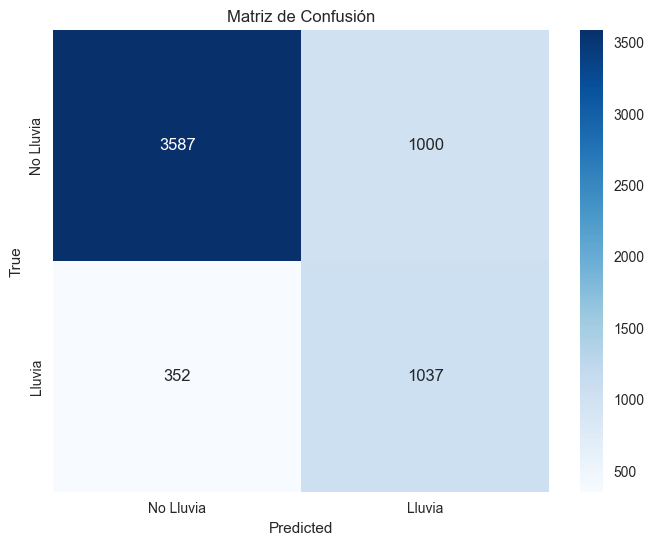

In [110]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Lluvia", "Lluvia"], yticklabels=["No Lluvia", "Lluvia"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matriz de Confusión")
plt.show()

Falsos positivos: Casos en que se predice lluvia para el día siguiente, pero que no sucedió.

Falsos negativos: Casos en que se predice que no lloverá al día siguiene y luego llueve.

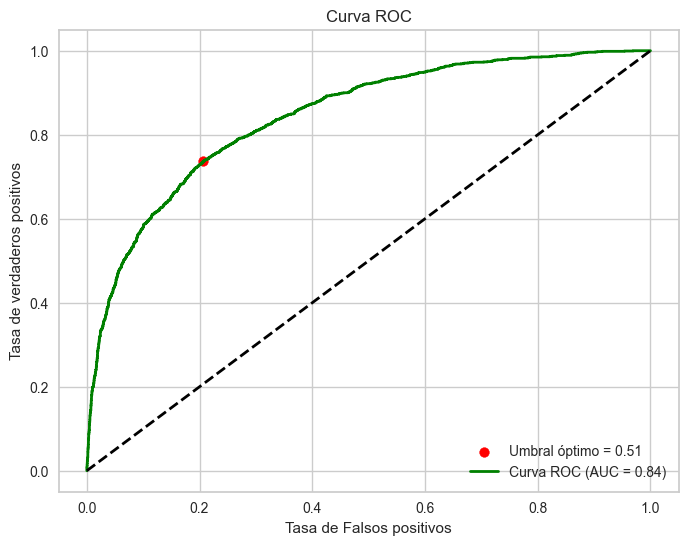

Umbral óptimo: 0.5127294108165911


In [111]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)              # Graficamos curva ROC y AUC
roc_auc = auc(fpr, tpr)

optimal_idx = (tpr - fpr).argmax()                                  # Buscamos el mejor umbral cuando la diferencia entre tpr y fpr sea máxima, ya que nos brindará el punto más cercano al (0,1)
optimal_threshold = thresholds[optimal_idx]

plt.figure(figsize=(8,6))
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Umbral óptimo = {optimal_threshold:.2f}')
plt.plot(fpr, tpr, color='green', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

print(f"Umbral óptimo: {optimal_threshold}")

In [112]:
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred_optimal)
precision = precision_score(y_test, y_pred_optimal)
recall = recall_score(y_test, y_pred_optimal)
f1 = f1_score(y_test, y_pred_optimal)

print(f"Métricas para umbral óptimo ({optimal_threshold:.2f}):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Métricas para umbral óptimo (0.51):
Accuracy: 0.7805
Precision: 0.5196
Recall: 0.7365
F1 Score: 0.6093


AUC : (El área bajo la curva es de 0.84, lo cual indica un modelo aceptable, recordando que un modelo aleatorio tendría un área de 0.5). 

Umbral óptimo: 0.5127
Leve mejoría de las métricas con el umbral óptimo

## Consigna 3

Random Classifier Metrics:
Accuracy: 0.4940
Precision: 0.2289
Recall: 0.4968
F1 Score: 0.3134
Matthews Correlation Coefficient (MCC): -0.01
Cohen's Kappa: -0.01


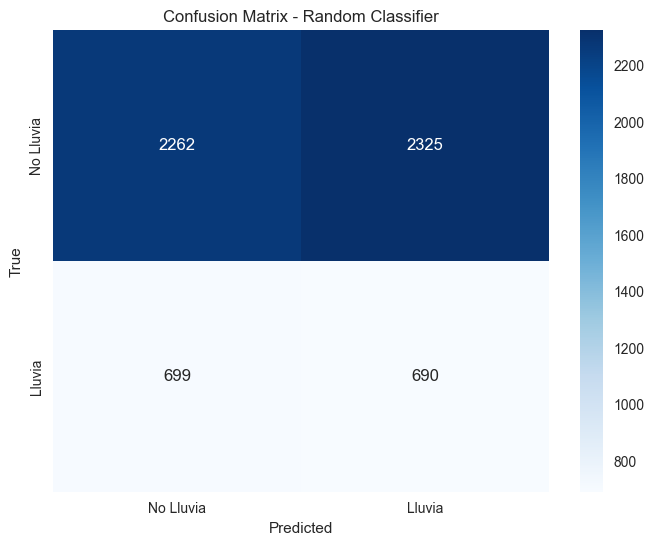

In [113]:
class RandomClassifier:                                                             # Implementamos clasificador aleatorio basado en la distribución de y_train, como modelo base
    def __init__(self):
        self.class_probs = None

    def fit(self, y_train):
        classes, counts = np.unique(y_train, return_counts=True)                    # Calcula las probabilidades de cada clase en y_train
        self.class_probs = counts / len(y_train)
        self.classes = classes
    
    def predict(self, X):
        n_samples = X.shape[0]                                                      # Genera predicciones aleatorias basada en la probabilidades de las clases
        return np.random.choice(self.classes, size=n_samples, p=self.class_probs)
    
    def predict_proba(self, X):
        n_samples = X.shape[0]                                                      # Devuelve las probabilidades de clase para todas las muestras.
        return np.tile(self.class_probs, (n_samples, 1))

random_clf = RandomClassifier()
random_clf.fit(y_train)

y_pred_random = random_clf.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred_random)
precision = precision_score(y_test, y_pred_random)
recall = recall_score(y_test, y_pred_random)
f1 = f1_score(y_test, y_pred_random)


print("Random Classifier Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

mcc = matthews_corrcoef(y_test, y_pred_random)     # correlación entre las predicciones y las etiquetas reales, MCC de +1 indica una predicción perfecta

print(f"Matthews Correlation Coefficient (MCC): {mcc:.2f}")

kappa = cohen_kappa_score(y_test, y_pred_random)   # nivel de acuerdo entre las predicciones del modelo y las etiquetas reales, ajustando por la probabilidad de acuerdo que ocurriría al azar

print(f"Cohen's Kappa: {kappa:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_random)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Lluvia", "Lluvia"], yticklabels=["No Lluvia", "Lluvia"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Random Classifier")
plt.show()


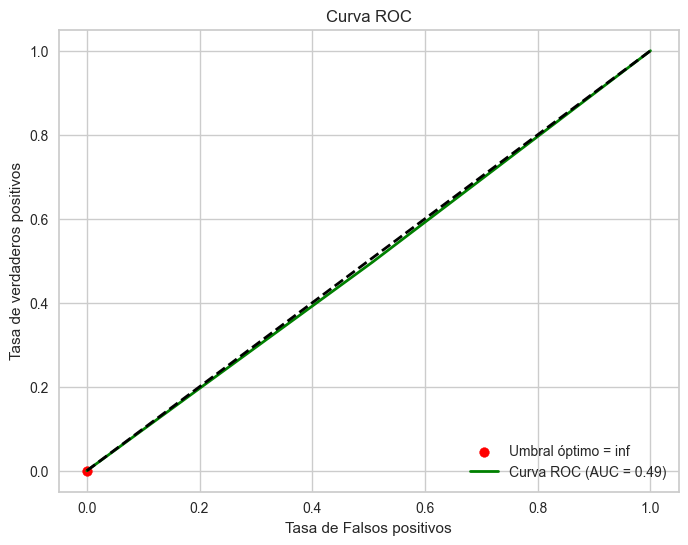

Umbral óptimo: inf


In [114]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_random)
roc_auc = auc(fpr, tpr)

optimal_idx = (tpr - fpr).argmax()                                  # Buscamos el mejor umbral cuando la diferencia entre tpr y fpr sea máxima, ya que nos brindará el punto más cercano al (0,1)
optimal_threshold = thresholds[optimal_idx]

plt.figure(figsize=(8,6))
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Umbral óptimo = {optimal_threshold:.2f}')
plt.plot(fpr, tpr, color='green', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

print(f"Umbral óptimo: {optimal_threshold}")

Hemos analizado otras métricas como Matthews Correlation Coefficient (MCC) y Cohen's Kappa.

MCC nos indican la correlación entre las predicciones y las etiquetas reales teniendo en cuenta verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos.

Cohen's Kappa mide el acuerdo entre las predicciones del modelo y las etiquetas reales, ajustando el valor en función de las predicciones que se podrían haber hecho al azar. Si bien puede ser útil en problemas multiclase, nos pareció una métrica interesante a la hora de analizar si el modelo busca más allá de una predicción aleatoria.

## Consigna 4

In [115]:
logreg_cv = LogisticRegressionCV(cv=5, random_state=0, max_iter=1000)       # Agregamos validación cruzada al modelo de regresión logística
logreg_cv.fit(X_train, y_train)

y_pred_cv = logreg_cv.predict(X_test)
y_pred_proba_cv = logreg_cv.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred_cv)
precision = precision_score(y_test, y_pred_cv)
recall = recall_score(y_test, y_pred_cv)
f1 = f1_score(y_test, y_pred_cv)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

mcc = matthews_corrcoef(y_test, y_pred_cv)     # correlación entre las predicciones y las etiquetas reales, MCC de +1 indica una predicción perfecta

print(f"Matthews Correlation Coefficient (MCC): {mcc:.2f}")

kappa = cohen_kappa_score(y_test, y_pred_cv)   # nivel de acuerdo entre las predicciones del modelo y las etiquetas reales, ajustando por la probabilidad de acuerdo que ocurriría al azar

print(f"Cohen's Kappa: {kappa:.2f}")


Accuracy: 0.7737617135207496
Precision: 0.509090909090909
Recall: 0.7458603311735061
F1 Score: 0.6051401869158879
Matthews Correlation Coefficient (MCC): 0.47
Cohen's Kappa: 0.45


Aun con cv de 5 folds, tenemos unas metricas similares

In [116]:
def objective(trial):                                                   # Para optimizar hiperparametros vamos a utilizar optuna debido a su eficiencia, utilizando f1 para la variable de lluvia positiva
    C = trial.suggest_int('Cs', 1, 200)                                 # Parámetro de regularización (rango entre 1 y 200)
    max_iter = trial.suggest_int('max_iter', 100, 2000)                 # Máximo número de iteraciones permitidas para la convergencia (rango entre 100 y 2000)

    params = {'Cs': C, 'max_iter': max_iter}

    logreg_optuna = LogisticRegressionCV(cv=5, random_state=0, **params)
    logreg_optuna.fit(X_train, y_train)

    y_pred_optuna = logreg_optuna.predict(X_test)
    f1_optuna = f1_score(y_test, y_pred_optuna)
    return f1_optuna

In [117]:
study = optuna.create_study(direction='maximize')                       # Buscamos maximizar el F1 Score
study.optimize(objective, n_trials=20)                                  # Ejecutamos 20 iteraciones de la función (trial)
best_params = study.best_params

[I 2024-12-18 20:25:51,177] A new study created in memory with name: no-name-6f6807bf-45e6-4441-a8d0-82756047fc80
[I 2024-12-18 20:25:53,073] Trial 0 finished with value: 0.6051401869158879 and parameters: {'Cs': 25, 'max_iter': 776}. Best is trial 0 with value: 0.6051401869158879.
[I 2024-12-18 20:26:01,011] Trial 1 finished with value: 0.6047869235259778 and parameters: {'Cs': 148, 'max_iter': 1061}. Best is trial 0 with value: 0.6051401869158879.
[I 2024-12-18 20:26:01,427] Trial 2 finished with value: 0.6055474452554744 and parameters: {'Cs': 2, 'max_iter': 1748}. Best is trial 2 with value: 0.6055474452554744.
[I 2024-12-18 20:26:09,511] Trial 3 finished with value: 0.604963503649635 and parameters: {'Cs': 154, 'max_iter': 1771}. Best is trial 2 with value: 0.6055474452554744.
[I 2024-12-18 20:26:17,574] Trial 4 finished with value: 0.604610446454625 and parameters: {'Cs': 156, 'max_iter': 728}. Best is trial 2 with value: 0.6055474452554744.
[I 2024-12-18 20:26:25,619] Trial 5 fi

La mejoria es casi nula en F1 debido a la simplicidad de una regresion logistica y sus hiperparametros, capaz en un modelo mas complejo seria notoria

## Consigna 5

In [68]:
logreg_cv = LogisticRegressionCV(cv=5, random_state=0, **best_params)
logreg_cv.fit(X_train, y_train)
y_pred_cv = logreg_cv.predict(X_test)
explainer = shap.Explainer(logreg_cv, X_train)
shap_values = explainer(X_test)

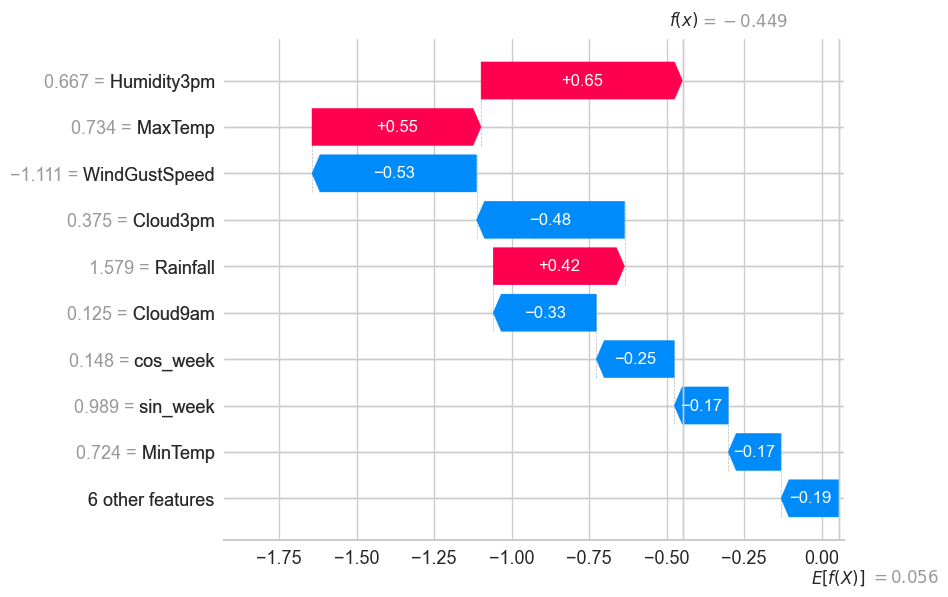

In [69]:
index=38
feature_names=X_test.columns.values
explanation = shap.Explanation(values=shap_values[index],
                               base_values=explainer.expected_value, # se muestra como un punto de partida específico para la instancia seleccionada
                               feature_names=feature_names)
shap.plots.waterfall(explanation)

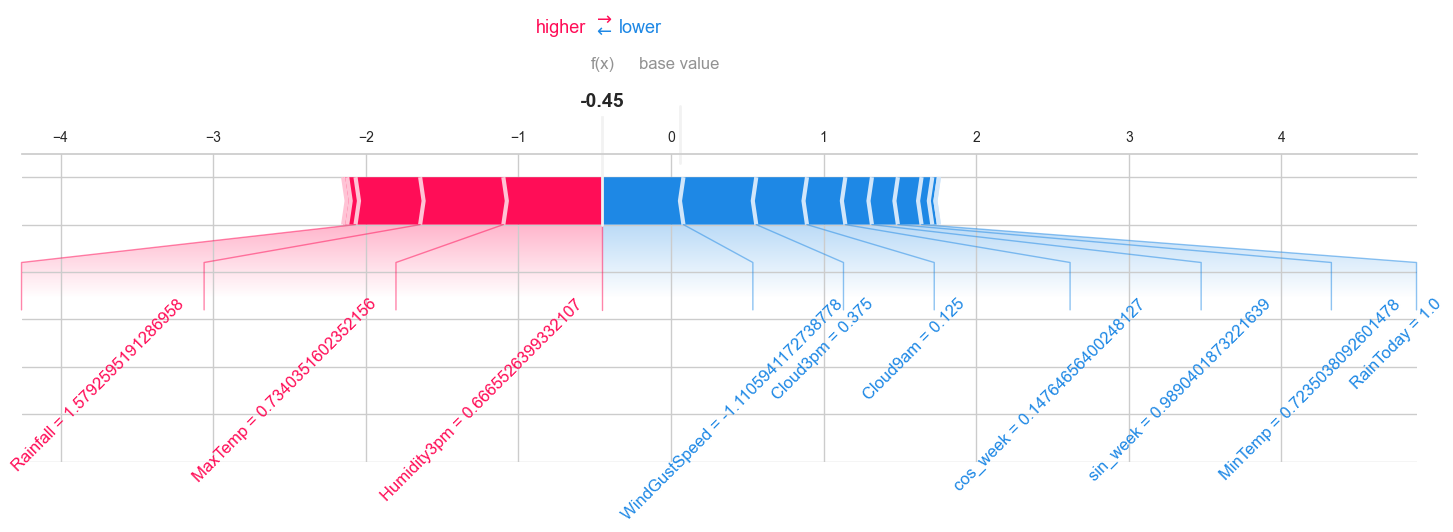

In [70]:
shap.force_plot(
    explainer.expected_value,     # se interpreta como el valor base global, por eso dan distintos números
    shap_values[index].values,    # valores SHAP de la instancia seleccionada
    X_test.iloc[index],           # seleccionamos al fila específica
    feature_names=feature_names,  
    matplotlib=True, 
    figsize=(18, 4),
    text_rotation=45
)

In [71]:
X_test.iloc[index]

MinTemp            0.723504
MaxTemp            0.734035
Rainfall           1.579260
Evaporation       -0.078393
WindGustSpeed     -1.110594
Humidity9am        0.559453
Humidity3pm        0.666553
Pressure3pm        0.257087
Cloud9am           0.125000
Cloud3pm           0.375000
RainToday          1.000000
sin_week           0.989040
cos_week           0.147647
WindGustDir_cos    0.923880
WindGustDir_sin    0.382683
Name: 10875, dtype: float64

In [72]:
df.iloc[index]

Date               2009-01-09 00:00:00
Location                        Albury
MinTemp                           12.5
MaxTemp                           28.4
Rainfall                           0.0
Evaporation                        NaN
Sunshine                           NaN
WindGustDir                        2.0
WindGustSpeed                     37.0
WindDir9am                         SSE
WindDir3pm                           S
WindSpeed9am                      20.0
WindSpeed3pm                       9.0
Humidity9am                       38.0
Humidity3pm                       16.0
Pressure9am                     1017.8
Pressure3pm                     1013.7
Cloud9am                           NaN
Cloud3pm                           NaN
Temp9am                           17.2
Temp3pm                           26.6
RainToday                            0
RainTomorrow                         0
sin_week                      0.234886
cos_week                      0.972023
WindGustDir_cos          

Pudimos ver que en esta observación, si bien las dos variables con mayor influencia en el modelo ("Humidity3pm","MaxTemp") nos podría haber indicado una gran probabilidad de lluvia para el día siguiente, el resto de las variables bajaron significativamente la estimación para concluir de manera acertada en la predicción. 

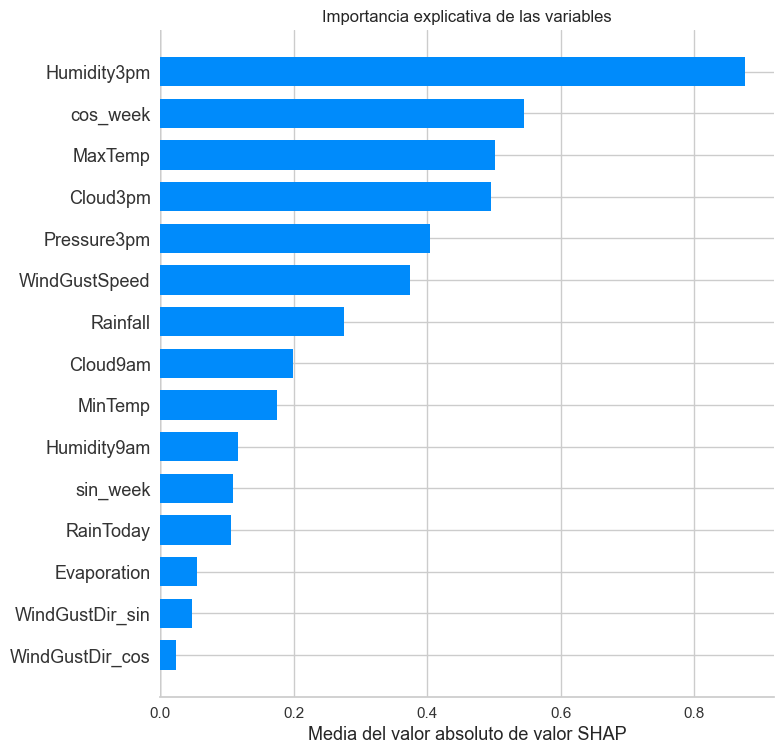

In [73]:
shap.summary_plot(shap_values, X_train, plot_type="bar", show = False)
fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel('Media del valor absoluto de valor SHAP')
ax.set_title('Importancia explicativa de las variables')
plt.show()

En este grafico se nota la importancia del valor absoluto SHAP de cada variable, pero no se logra distinguir si nos da menos o mas chances logaritmicas de la lluvia, ademas de no saber en que valores de cada variable se obtienen estas chances.

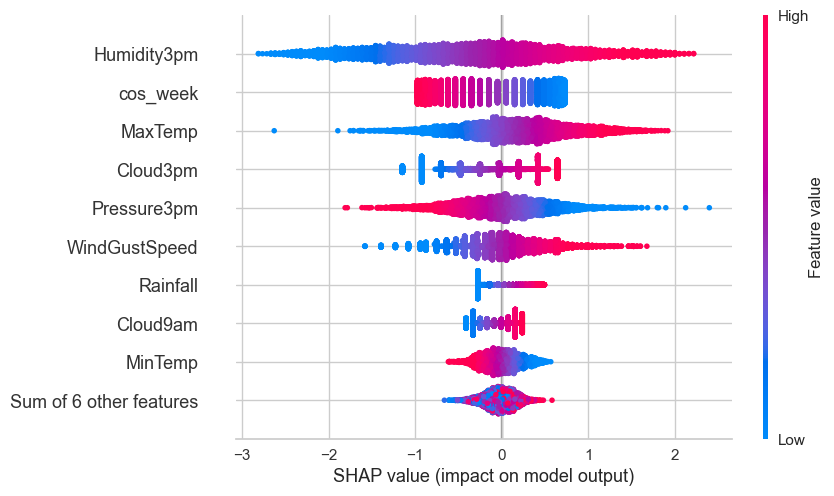

In [74]:
shap.plots.beeswarm(shap_values)

En linea con lo visto anteriormente, humedad 3pm tiene una importancia predictiva alta. Al ser un modelo lineal, se nota el gradiente en todas las variables, ya sea de valores altos a bajos o viceversa.

## Consigna 6

In [75]:
model_setup = setup(data = X_train, target = y_train, session_id = 123)

,Description,Value
0,Session id,123
1,Target,RainTomorrow
2,Target type,Binary
3,Original data shape,"(36688, 16)"
4,Transformed data shape,"(36688, 16)"
5,Transformed train set shape,"(25681, 16)"
6,Transformed test set shape,"(11007, 16)"
7,Numeric features,15
8,Preprocess,True
9,Imputation type,simple


In [76]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9322,0.9816,0.9386,0.9269,0.9327,0.8645,0.8646,0.4680
rf,Random Forest Classifier,0.9204,0.9785,0.9506,0.8966,0.9228,0.8409,0.8425,0.7710
dt,Decision Tree Classifier,0.8748,0.8748,0.9418,0.8305,0.8827,0.7495,0.7564,0.0580
lightgbm,Light Gradient Boosting Machine,0.8234,0.9079,0.8372,0.8149,0.8258,0.6468,0.6472,0.2590
knn,K Neighbors Classifier,0.7979,0.8771,0.8463,0.7716,0.8072,0.5957,0.5986,0.6420
gbc,Gradient Boosting Classifier,0.7897,0.8744,0.7853,0.7924,0.7888,0.5794,0.5795,0.9390
lr,Logistic Regression,0.7768,0.8601,0.7738,0.7784,0.7761,0.5535,0.5536,0.6620
ridge,Ridge Classifier,0.7758,0.8598,0.7719,0.7780,0.7749,0.5516,0.5516,0.0200
lda,Linear Discriminant Analysis,0.7758,0.8598,0.7720,0.7780,0.7750,0.5517,0.5517,0.0240
svm,SVM - Linear Kernel,0.7727,0.8556,0.7742,0.7730,0.7727,0.5454,0.5466,0.0420


In [77]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [78]:
predictions= predict_model(best, data = X_test)

In [79]:
print(classification_report(y_test, predictions['prediction_label']))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      4587
           1       0.71      0.51      0.59      1389

    accuracy                           0.84      5976
   macro avg       0.79      0.72      0.75      5976
weighted avg       0.83      0.84      0.83      5976



Este modelo nos sesga a pensar que es mucho mejor que la regresion logistica, pero viendo el detalle de las metricas en realidad tiene una performance similar, tiendo una recall mas baja a cambio de mas precision cuando llueve

## Consigna 7

### NN

In [120]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(in_features=len(X_train.columns), out_features=8)  # Primera capa lineal
        self.relu = nn.LeakyReLU(0.1)  # Función de activación Leaky ReLU
        self.lin2 = nn.Linear(in_features=8, out_features=4)  # 2da capa
        self.relu2 = nn.LeakyReLU(0.1)
        self.lin3 = nn.Linear(in_features=4, out_features=1)  # Capa salida

    def forward(self, x):
        x = self.lin1(x)  # Pasar la entrada por cada capa y funciones
        x = self.relu(x)  
        x = self.lin2(x)  
        x = self.relu2(x)  
        x = self.lin3(x)  
        return x  

nntwk = NeuralNetwork()
nntwk.to(device)
print(nntwk)


class CustomDataset(Dataset):           # Definimos una clase de conjunto de datos personalizada para cargar datos
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)  # Numero de muestras

    def __getitem__(self, idx):
        return self.X.iloc[idx].values, self.y.iloc[idx]

print(sum(p.numel() for p in nntwk.parameters()))  # 15*8 + 8 + 8*4 + 4 + 4*1 + 1 = 169 Numero total de parámetros en el modelo

loss_function = torch.nn.BCEWithLogitsLoss()  # Definir la función de pérdida y el optimizador Binary Cross-Entropy with Logits
optimizer = torch.optim.Adam(nntwk.parameters())  # Optimizador Adam

train_dataset = CustomDataset(X_train, y_train)     # Creamos conjuntos de datos para entrenamiento y pruebas
test_dataset = CustomDataset(X_test, y_test)    

train_dataloader = DataLoader(train_dataset, batch_size=180, shuffle=True)
validate_dataloader = DataLoader(test_dataset, batch_size=180, shuffle=True)


def test(dataloader, model, loss_function):         # Función para probar el modelo con datos de validación y calcular la puntuación F1
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() 
    test_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X, y in dataloader:
            X = torch.tensor(X, dtype=torch.float32)
            X, y = X.to(device), y.to(device)
            pred = model(X)  # Predicciones
            pred_sigmoid = torch.sigmoid(pred)  # Aplicamos sigmoide para probabilidades
            test_loss += loss_function(pred, y.unsqueeze(1).float()).item()  # Calculamos la pérdida
            all_preds.extend((pred_sigmoid > 0.5).cpu().numpy())  # Binarizamos predicciones
            all_labels.extend(y.cpu().numpy())  # Agarramos etiquetas verdaderas
    test_loss /= num_batches  # Pérdida promedio de prueba
    f1 = f1_score(all_labels, all_preds)  # F1 score
    print(f"Test Error: \n F1 Score: {f1:>0.3f}, Avg loss: {test_loss:>8f} \n")
    return test_loss, f1

def train(dataloader, model, loss_function, optimizer):     # Funcion para entrenar el modelo
    model.train()  # Se establece en modo entrenamiento
    for batch, (X, y) in enumerate(dataloader):
        X = torch.tensor(X, dtype=torch.float32)
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_function(pred, y.unsqueeze(1).float())  # Calculamos la pérdida

        loss.backward()  # Backpropagation
        optimizer.step()  # Actualizamos parametros del  modelo
        optimizer.zero_grad() 

NeuralNetwork(
  (lin1): Linear(in_features=15, out_features=8, bias=True)
  (relu): LeakyReLU(negative_slope=0.1)
  (lin2): Linear(in_features=8, out_features=4, bias=True)
  (relu2): LeakyReLU(negative_slope=0.1)
  (lin3): Linear(in_features=4, out_features=1, bias=True)
)
169


In [121]:
epochs = 50
for e in range(epochs):
    print(f"Epoch {e+1}\n-------------------------------")
    train(train_dataloader, nntwk, loss_function, optimizer)  # Entrenar con datos de entrenamiento
    test(validate_dataloader, nntwk, loss_function)  # Prueba sobre datos de validación

Epoch 1
-------------------------------
Test Error: 
 F1 Score: 0.566, Avg loss: 0.538471 

Epoch 2
-------------------------------
Test Error: 
 F1 Score: 0.599, Avg loss: 0.486168 

Epoch 3
-------------------------------
Test Error: 
 F1 Score: 0.595, Avg loss: 0.490026 

Epoch 4
-------------------------------
Test Error: 
 F1 Score: 0.604, Avg loss: 0.470531 

Epoch 5
-------------------------------
Test Error: 
 F1 Score: 0.606, Avg loss: 0.464169 

Epoch 6
-------------------------------
Test Error: 
 F1 Score: 0.606, Avg loss: 0.466849 

Epoch 7
-------------------------------
Test Error: 
 F1 Score: 0.607, Avg loss: 0.476383 

Epoch 8
-------------------------------
Test Error: 
 F1 Score: 0.609, Avg loss: 0.464923 

Epoch 9
-------------------------------
Test Error: 
 F1 Score: 0.605, Avg loss: 0.468626 

Epoch 10
-------------------------------
Test Error: 
 F1 Score: 0.610, Avg loss: 0.466540 

Epoch 11
-------------------------------
Test Error: 
 F1 Score: 0.611, Avg los

Converge rapidamente en un F1 de 0.6

In [122]:
test(validate_dataloader, nntwk, loss_function)         # Prueba final y guardado del modelo

Test Error: 
 F1 Score: 0.604, Avg loss: 0.456583 



(0.4565833982299356, 0.6038942167974426)

In [123]:
torch.save(nntwk.state_dict(), 'model.pth')             # Guardar estado del modelo

In [124]:
model = NeuralNetwork()                                                 # Cargar el modelo
model.load_state_dict(torch.load('model.pth', weights_only=True))       # Cargar estado guardado
model.eval()                                                            # Establecer el modelo en modo de evaluación

NeuralNetwork(
  (lin1): Linear(in_features=15, out_features=8, bias=True)
  (relu): LeakyReLU(negative_slope=0.1)
  (lin2): Linear(in_features=8, out_features=4, bias=True)
  (relu2): LeakyReLU(negative_slope=0.1)
  (lin3): Linear(in_features=4, out_features=1, bias=True)
)

### optuna

In [125]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

def trial_model(trial):
    """Define a neural network model dynamically based on trial parameters."""
    n_hidden = trial.suggest_int('n_hidden', 1, 4)  # Optimiza el num de capas ocultas

    layers = []  # para guardas las capas del modelo
    in_features = len(X_train.columns)  # Inicio con las columnas de la capa de entrada

    for i in range(n_hidden):
        out_features = trial.suggest_int(f'n_units_l{i}', 4, 30)  # Optimiza neuronas para la siguiente capa
        layers.append(nn.Linear(in_features, out_features))  # Agrega una capa full conectada
        layers.append(nn.ReLU())  # ReLU activacion
        p = trial.suggest_float(f'dropout_l{i}', 0.01, 0.6)  # Optimizar dropout para la regularizacion
        layers.append(nn.Dropout(p))  # agrega dropout para evitar overfitting
        in_features = out_features  # Tamaño de entrada para la siguiente capa

    layers.append(nn.Linear(in_features, 1))  # agrega capa de salida
    model = nn.Sequential(*layers)  # Crea la red neuronal

    return model

epochs = 25 # numero de epocas de entrenamiento

def objective(trial):
    # Generar modelo basado en parametros de prueba
    model = trial_model(trial)
    model.to(device)

    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True) # Optimizar lr
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_dataloader = DataLoader(train_dataset, batch_size=180, shuffle=True)
    validate_dataloader = DataLoader(test_dataset, batch_size=180, shuffle=True)

    for e in range(epochs):
        train(train_dataloader, model, loss_function, optimizer)  # Entrenar el modelo
        test_loss, test_f1 = test(validate_dataloader, model, loss_function)  # Evaluar F1 score

        trial.report(test_f1, e)  
        if trial.should_prune():  # Corte temprano si no es prometedor
            raise optuna.exceptions.TrialPruned()

    return test_f1  # Retorna el F1


In [126]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # 1000 pruebas

[I 2024-12-18 20:49:13,077] A new study created in memory with name: no-name-a2f685ba-f5fc-472a-9c16-06c227e15dc2


Test Error: 
 F1 Score: 0.577, Avg loss: 0.562891 

Test Error: 
 F1 Score: 0.587, Avg loss: 0.501374 

Test Error: 
 F1 Score: 0.588, Avg loss: 0.489415 

Test Error: 
 F1 Score: 0.598, Avg loss: 0.482118 

Test Error: 
 F1 Score: 0.602, Avg loss: 0.469807 

Test Error: 
 F1 Score: 0.605, Avg loss: 0.468666 

Test Error: 
 F1 Score: 0.604, Avg loss: 0.474951 

Test Error: 
 F1 Score: 0.612, Avg loss: 0.467884 

Test Error: 
 F1 Score: 0.611, Avg loss: 0.464990 

Test Error: 
 F1 Score: 0.615, Avg loss: 0.465656 

Test Error: 
 F1 Score: 0.609, Avg loss: 0.484499 

Test Error: 
 F1 Score: 0.613, Avg loss: 0.469730 

Test Error: 
 F1 Score: 0.613, Avg loss: 0.457004 

Test Error: 
 F1 Score: 0.612, Avg loss: 0.464562 

Test Error: 
 F1 Score: 0.609, Avg loss: 0.472992 

Test Error: 
 F1 Score: 0.613, Avg loss: 0.460674 

Test Error: 
 F1 Score: 0.614, Avg loss: 0.464020 

Test Error: 
 F1 Score: 0.611, Avg loss: 0.461752 

Test Error: 
 F1 Score: 0.612, Avg loss: 0.466680 

Test Error: 

[I 2024-12-18 20:50:26,584] Trial 0 finished with value: 0.6130714943234121 and parameters: {'n_hidden': 4, 'n_units_l0': 6, 'dropout_l0': 0.04047999690449343, 'n_units_l1': 26, 'dropout_l1': 0.10434742098958766, 'n_units_l2': 25, 'dropout_l2': 0.5002001871389775, 'n_units_l3': 12, 'dropout_l3': 0.1335917686082802, 'lr': 0.00045404324080175836}. Best is trial 0 with value: 0.6130714943234121.


Test Error: 
 F1 Score: 0.613, Avg loss: 0.462076 

Test Error: 
 F1 Score: 0.473, Avg loss: 0.688378 

Test Error: 
 F1 Score: 0.538, Avg loss: 0.640785 

Test Error: 
 F1 Score: 0.566, Avg loss: 0.591154 

Test Error: 
 F1 Score: 0.575, Avg loss: 0.551303 

Test Error: 
 F1 Score: 0.583, Avg loss: 0.525761 

Test Error: 
 F1 Score: 0.589, Avg loss: 0.515282 

Test Error: 
 F1 Score: 0.596, Avg loss: 0.501589 

Test Error: 
 F1 Score: 0.599, Avg loss: 0.499982 

Test Error: 
 F1 Score: 0.600, Avg loss: 0.492975 

Test Error: 
 F1 Score: 0.601, Avg loss: 0.486823 

Test Error: 
 F1 Score: 0.603, Avg loss: 0.484953 

Test Error: 
 F1 Score: 0.603, Avg loss: 0.481551 

Test Error: 
 F1 Score: 0.604, Avg loss: 0.478838 

Test Error: 
 F1 Score: 0.606, Avg loss: 0.479602 

Test Error: 
 F1 Score: 0.606, Avg loss: 0.479773 

Test Error: 
 F1 Score: 0.608, Avg loss: 0.476531 

Test Error: 
 F1 Score: 0.607, Avg loss: 0.474265 

Test Error: 
 F1 Score: 0.608, Avg loss: 0.475050 

Test Error: 

[I 2024-12-18 20:51:33,562] Trial 1 finished with value: 0.6092485549132948 and parameters: {'n_hidden': 1, 'n_units_l0': 20, 'dropout_l0': 0.24112806826579472, 'lr': 0.0001911115384153899}. Best is trial 0 with value: 0.6130714943234121.


Test Error: 
 F1 Score: 0.609, Avg loss: 0.470214 

Test Error: 
 F1 Score: 0.377, Avg loss: 0.697831 

Test Error: 
 F1 Score: 0.447, Avg loss: 0.693367 

Test Error: 
 F1 Score: 0.516, Avg loss: 0.673700 

Test Error: 
 F1 Score: 0.533, Avg loss: 0.631924 

Test Error: 
 F1 Score: 0.547, Avg loss: 0.587936 

Test Error: 
 F1 Score: 0.558, Avg loss: 0.553387 

Test Error: 
 F1 Score: 0.569, Avg loss: 0.534240 

Test Error: 
 F1 Score: 0.571, Avg loss: 0.524748 

Test Error: 
 F1 Score: 0.576, Avg loss: 0.515644 

Test Error: 
 F1 Score: 0.578, Avg loss: 0.510877 

Test Error: 
 F1 Score: 0.584, Avg loss: 0.511295 

Test Error: 
 F1 Score: 0.587, Avg loss: 0.505689 

Test Error: 
 F1 Score: 0.587, Avg loss: 0.499516 

Test Error: 
 F1 Score: 0.588, Avg loss: 0.500981 

Test Error: 
 F1 Score: 0.591, Avg loss: 0.501534 

Test Error: 
 F1 Score: 0.593, Avg loss: 0.496696 

Test Error: 
 F1 Score: 0.593, Avg loss: 0.491821 

Test Error: 
 F1 Score: 0.593, Avg loss: 0.499968 

Test Error: 

[I 2024-12-18 20:52:39,946] Trial 2 finished with value: 0.6007224228952487 and parameters: {'n_hidden': 4, 'n_units_l0': 28, 'dropout_l0': 0.40402810578741716, 'n_units_l1': 24, 'dropout_l1': 0.07513102736456413, 'n_units_l2': 16, 'dropout_l2': 0.0573357909534451, 'n_units_l3': 18, 'dropout_l3': 0.43968209271113773, 'lr': 5.4694317065799426e-05}. Best is trial 0 with value: 0.6130714943234121.


Test Error: 
 F1 Score: 0.601, Avg loss: 0.485874 

Test Error: 
 F1 Score: 0.598, Avg loss: 0.507613 

Test Error: 
 F1 Score: 0.601, Avg loss: 0.485588 

Test Error: 
 F1 Score: 0.600, Avg loss: 0.486542 

Test Error: 
 F1 Score: 0.603, Avg loss: 0.472361 

Test Error: 
 F1 Score: 0.600, Avg loss: 0.481897 

Test Error: 
 F1 Score: 0.595, Avg loss: 0.493343 

Test Error: 
 F1 Score: 0.607, Avg loss: 0.465876 

Test Error: 
 F1 Score: 0.610, Avg loss: 0.473141 

Test Error: 
 F1 Score: 0.606, Avg loss: 0.479245 

Test Error: 
 F1 Score: 0.611, Avg loss: 0.468746 

Test Error: 
 F1 Score: 0.606, Avg loss: 0.477085 

Test Error: 
 F1 Score: 0.605, Avg loss: 0.486791 

Test Error: 
 F1 Score: 0.607, Avg loss: 0.486334 

Test Error: 
 F1 Score: 0.607, Avg loss: 0.484724 

Test Error: 
 F1 Score: 0.610, Avg loss: 0.477607 

Test Error: 
 F1 Score: 0.612, Avg loss: 0.485868 

Test Error: 
 F1 Score: 0.613, Avg loss: 0.471985 

Test Error: 
 F1 Score: 0.618, Avg loss: 0.480441 

Test Error: 

[I 2024-12-18 20:53:43,404] Trial 3 finished with value: 0.6085680751173709 and parameters: {'n_hidden': 3, 'n_units_l0': 15, 'dropout_l0': 0.5853339125871095, 'n_units_l1': 4, 'dropout_l1': 0.5098285347694281, 'n_units_l2': 17, 'dropout_l2': 0.08114937557769461, 'lr': 0.003882399856612334}. Best is trial 0 with value: 0.6130714943234121.


Test Error: 
 F1 Score: 0.609, Avg loss: 0.476062 

Test Error: 
 F1 Score: 0.377, Avg loss: 0.735258 

Test Error: 
 F1 Score: 0.377, Avg loss: 0.731725 

Test Error: 
 F1 Score: 0.377, Avg loss: 0.729081 

Test Error: 
 F1 Score: 0.377, Avg loss: 0.725403 

Test Error: 
 F1 Score: 0.377, Avg loss: 0.722124 

Test Error: 
 F1 Score: 0.377, Avg loss: 0.719500 

Test Error: 
 F1 Score: 0.377, Avg loss: 0.716158 

Test Error: 
 F1 Score: 0.377, Avg loss: 0.713088 

Test Error: 
 F1 Score: 0.379, Avg loss: 0.709837 

Test Error: 
 F1 Score: 0.389, Avg loss: 0.705901 

Test Error: 
 F1 Score: 0.405, Avg loss: 0.702815 

Test Error: 
 F1 Score: 0.431, Avg loss: 0.698367 

Test Error: 
 F1 Score: 0.453, Avg loss: 0.694205 

Test Error: 
 F1 Score: 0.474, Avg loss: 0.689765 

Test Error: 
 F1 Score: 0.511, Avg loss: 0.684549 

Test Error: 
 F1 Score: 0.524, Avg loss: 0.679526 

Test Error: 
 F1 Score: 0.533, Avg loss: 0.673358 

Test Error: 
 F1 Score: 0.539, Avg loss: 0.667445 

Test Error: 

[I 2024-12-18 20:54:46,044] Trial 4 finished with value: 0.5526095450739603 and parameters: {'n_hidden': 3, 'n_units_l0': 8, 'dropout_l0': 0.17147928221255826, 'n_units_l1': 28, 'dropout_l1': 0.3104486821122014, 'n_units_l2': 23, 'dropout_l2': 0.3529763923925854, 'lr': 1.283935140116025e-05}. Best is trial 0 with value: 0.6130714943234121.


Test Error: 
 F1 Score: 0.553, Avg loss: 0.623058 



[I 2024-12-18 20:54:48,579] Trial 5 pruned. 


Test Error: 
 F1 Score: 0.377, Avg loss: 0.764226 

Test Error: 
 F1 Score: 0.567, Avg loss: 0.639552 

Test Error: 
 F1 Score: 0.600, Avg loss: 0.517304 

Test Error: 
 F1 Score: 0.596, Avg loss: 0.495994 

Test Error: 
 F1 Score: 0.594, Avg loss: 0.493893 

Test Error: 
 F1 Score: 0.592, Avg loss: 0.486031 

Test Error: 
 F1 Score: 0.597, Avg loss: 0.471148 

Test Error: 
 F1 Score: 0.596, Avg loss: 0.471419 

Test Error: 
 F1 Score: 0.596, Avg loss: 0.467267 

Test Error: 
 F1 Score: 0.594, Avg loss: 0.465044 



[I 2024-12-18 20:55:15,175] Trial 6 pruned. 


Test Error: 
 F1 Score: 0.595, Avg loss: 0.467421 



[I 2024-12-18 20:55:17,625] Trial 7 pruned. 


Test Error: 
 F1 Score: 0.296, Avg loss: 0.659672 

Test Error: 
 F1 Score: 0.613, Avg loss: 0.456419 

Test Error: 
 F1 Score: 0.591, Avg loss: 0.528892 

Test Error: 
 F1 Score: 0.612, Avg loss: 0.456239 

Test Error: 
 F1 Score: 0.610, Avg loss: 0.463153 

Test Error: 
 F1 Score: 0.596, Avg loss: 0.501039 

Test Error: 
 F1 Score: 0.606, Avg loss: 0.444357 

Test Error: 
 F1 Score: 0.617, Avg loss: 0.441986 

Test Error: 
 F1 Score: 0.615, Avg loss: 0.451181 

Test Error: 
 F1 Score: 0.612, Avg loss: 0.457586 

Test Error: 
 F1 Score: 0.600, Avg loss: 0.505505 

Test Error: 
 F1 Score: 0.603, Avg loss: 0.470354 

Test Error: 
 F1 Score: 0.612, Avg loss: 0.485073 

Test Error: 
 F1 Score: 0.620, Avg loss: 0.475837 

Test Error: 
 F1 Score: 0.604, Avg loss: 0.461824 

Test Error: 
 F1 Score: 0.603, Avg loss: 0.473807 

Test Error: 
 F1 Score: 0.603, Avg loss: 0.468643 

Test Error: 
 F1 Score: 0.607, Avg loss: 0.465946 

Test Error: 
 F1 Score: 0.611, Avg loss: 0.454609 

Test Error: 

[I 2024-12-18 20:56:19,367] Trial 8 finished with value: 0.6158357771260997 and parameters: {'n_hidden': 2, 'n_units_l0': 24, 'dropout_l0': 0.443635309085171, 'n_units_l1': 27, 'dropout_l1': 0.23905886295310064, 'lr': 0.027086431795626687}. Best is trial 8 with value: 0.6158357771260997.


Test Error: 
 F1 Score: 0.616, Avg loss: 0.482594 

Test Error: 
 F1 Score: 0.612, Avg loss: 0.449137 

Test Error: 
 F1 Score: 0.596, Avg loss: 0.494323 

Test Error: 
 F1 Score: 0.613, Avg loss: 0.459288 

Test Error: 
 F1 Score: 0.614, Avg loss: 0.445050 

Test Error: 
 F1 Score: 0.615, Avg loss: 0.453022 

Test Error: 
 F1 Score: 0.607, Avg loss: 0.467614 

Test Error: 
 F1 Score: 0.615, Avg loss: 0.451795 

Test Error: 
 F1 Score: 0.610, Avg loss: 0.469224 

Test Error: 
 F1 Score: 0.615, Avg loss: 0.470837 

Test Error: 
 F1 Score: 0.624, Avg loss: 0.441098 

Test Error: 
 F1 Score: 0.613, Avg loss: 0.460531 

Test Error: 
 F1 Score: 0.610, Avg loss: 0.465344 

Test Error: 
 F1 Score: 0.617, Avg loss: 0.469717 

Test Error: 
 F1 Score: 0.615, Avg loss: 0.449254 

Test Error: 
 F1 Score: 0.607, Avg loss: 0.491648 

Test Error: 
 F1 Score: 0.618, Avg loss: 0.444753 

Test Error: 
 F1 Score: 0.616, Avg loss: 0.438902 

Test Error: 
 F1 Score: 0.607, Avg loss: 0.467080 

Test Error: 

[I 2024-12-18 20:57:26,942] Trial 9 finished with value: 0.6167664670658682 and parameters: {'n_hidden': 4, 'n_units_l0': 18, 'dropout_l0': 0.06928876312906856, 'n_units_l1': 23, 'dropout_l1': 0.02198090028064246, 'n_units_l2': 27, 'dropout_l2': 0.1372618139810563, 'n_units_l3': 18, 'dropout_l3': 0.30405800939603184, 'lr': 0.003232894492922942}. Best is trial 9 with value: 0.6167664670658682.


Test Error: 
 F1 Score: 0.617, Avg loss: 0.438571 

Test Error: 
 F1 Score: 0.611, Avg loss: 0.469848 

Test Error: 
 F1 Score: 0.608, Avg loss: 0.483800 

Test Error: 
 F1 Score: 0.612, Avg loss: 0.468657 

Test Error: 
 F1 Score: 0.615, Avg loss: 0.451043 

Test Error: 
 F1 Score: 0.616, Avg loss: 0.485045 

Test Error: 
 F1 Score: 0.616, Avg loss: 0.464110 

Test Error: 
 F1 Score: 0.624, Avg loss: 0.468186 

Test Error: 
 F1 Score: 0.621, Avg loss: 0.472212 

Test Error: 
 F1 Score: 0.625, Avg loss: 0.456788 

Test Error: 
 F1 Score: 0.625, Avg loss: 0.441953 

Test Error: 
 F1 Score: 0.629, Avg loss: 0.444914 

Test Error: 
 F1 Score: 0.611, Avg loss: 0.499205 

Test Error: 
 F1 Score: 0.620, Avg loss: 0.459397 

Test Error: 
 F1 Score: 0.622, Avg loss: 0.456497 

Test Error: 
 F1 Score: 0.626, Avg loss: 0.444411 

Test Error: 
 F1 Score: 0.617, Avg loss: 0.454168 

Test Error: 
 F1 Score: 0.624, Avg loss: 0.448054 

Test Error: 
 F1 Score: 0.620, Avg loss: 0.453621 

Test Error: 

[I 2024-12-18 20:58:32,533] Trial 10 finished with value: 0.6178813809383299 and parameters: {'n_hidden': 3, 'n_units_l0': 22, 'dropout_l0': 0.042683326397076005, 'n_units_l1': 18, 'dropout_l1': 0.021951161303502942, 'n_units_l2': 6, 'dropout_l2': 0.26762850756068624, 'lr': 0.0037252054034432017}. Best is trial 10 with value: 0.6178813809383299.


Test Error: 
 F1 Score: 0.618, Avg loss: 0.468909 

Test Error: 
 F1 Score: 0.600, Avg loss: 0.475066 

Test Error: 
 F1 Score: 0.587, Avg loss: 0.487571 

Test Error: 
 F1 Score: 0.600, Avg loss: 0.469670 

Test Error: 
 F1 Score: 0.611, Avg loss: 0.466836 

Test Error: 
 F1 Score: 0.598, Avg loss: 0.468614 

Test Error: 
 F1 Score: 0.606, Avg loss: 0.461155 

Test Error: 
 F1 Score: 0.609, Avg loss: 0.479647 

Test Error: 
 F1 Score: 0.605, Avg loss: 0.471507 

Test Error: 
 F1 Score: 0.607, Avg loss: 0.470091 

Test Error: 
 F1 Score: 0.618, Avg loss: 0.449891 

Test Error: 
 F1 Score: 0.613, Avg loss: 0.440367 

Test Error: 
 F1 Score: 0.603, Avg loss: 0.455824 

Test Error: 
 F1 Score: 0.606, Avg loss: 0.456081 

Test Error: 
 F1 Score: 0.600, Avg loss: 0.463892 

Test Error: 
 F1 Score: 0.613, Avg loss: 0.441334 

Test Error: 
 F1 Score: 0.610, Avg loss: 0.459322 

Test Error: 
 F1 Score: 0.602, Avg loss: 0.463743 

Test Error: 
 F1 Score: 0.597, Avg loss: 0.459801 

Test Error: 

[I 2024-12-18 20:59:50,856] Trial 11 finished with value: 0.6065753424657534 and parameters: {'n_hidden': 3, 'n_units_l0': 21, 'dropout_l0': 0.013819363389753467, 'n_units_l1': 18, 'dropout_l1': 0.03650138130069495, 'n_units_l2': 5, 'dropout_l2': 0.258726974252668, 'lr': 0.004503574534617548}. Best is trial 10 with value: 0.6178813809383299.


Test Error: 
 F1 Score: 0.607, Avg loss: 0.450494 

Test Error: 
 F1 Score: 0.604, Avg loss: 0.546094 

Test Error: 
 F1 Score: 0.621, Avg loss: 0.462441 

Test Error: 
 F1 Score: 0.594, Avg loss: 0.507696 

Test Error: 
 F1 Score: 0.593, Avg loss: 0.515050 

Test Error: 
 F1 Score: 0.595, Avg loss: 0.513109 

Test Error: 
 F1 Score: 0.600, Avg loss: 0.507211 

Test Error: 
 F1 Score: 0.608, Avg loss: 0.488711 

Test Error: 
 F1 Score: 0.603, Avg loss: 0.493427 

Test Error: 
 F1 Score: 0.597, Avg loss: 0.517246 

Test Error: 
 F1 Score: 0.606, Avg loss: 0.497182 

Test Error: 
 F1 Score: 0.605, Avg loss: 0.495777 

Test Error: 
 F1 Score: 0.605, Avg loss: 0.494360 

Test Error: 
 F1 Score: 0.603, Avg loss: 0.514557 

Test Error: 
 F1 Score: 0.609, Avg loss: 0.493207 

Test Error: 
 F1 Score: 0.612, Avg loss: 0.480152 

Test Error: 
 F1 Score: 0.611, Avg loss: 0.496643 

Test Error: 
 F1 Score: 0.620, Avg loss: 0.474437 

Test Error: 
 F1 Score: 0.614, Avg loss: 0.489202 

Test Error: 

[I 2024-12-18 21:01:07,379] Trial 12 finished with value: 0.6108123407868666 and parameters: {'n_hidden': 4, 'n_units_l0': 13, 'dropout_l0': 0.09599065488821151, 'n_units_l1': 17, 'dropout_l1': 0.14880456889427596, 'n_units_l2': 4, 'dropout_l2': 0.3054001675156467, 'n_units_l3': 28, 'dropout_l3': 0.2296771254257537, 'lr': 0.0035620188292382043}. Best is trial 10 with value: 0.6178813809383299.


Test Error: 
 F1 Score: 0.611, Avg loss: 0.499514 

Test Error: 
 F1 Score: 0.605, Avg loss: 0.440775 

Test Error: 
 F1 Score: 0.614, Avg loss: 0.415208 

Test Error: 
 F1 Score: 0.621, Avg loss: 0.486771 

Test Error: 
 F1 Score: 0.601, Avg loss: 0.437625 

Test Error: 
 F1 Score: 0.597, Avg loss: 0.494170 

Test Error: 
 F1 Score: 0.607, Avg loss: 0.491638 

Test Error: 
 F1 Score: 0.618, Avg loss: 0.451457 

Test Error: 
 F1 Score: 0.602, Avg loss: 0.487245 

Test Error: 
 F1 Score: 0.617, Avg loss: 0.471007 

Test Error: 
 F1 Score: 0.609, Avg loss: 0.476779 

Test Error: 
 F1 Score: 0.586, Avg loss: 0.520385 

Test Error: 
 F1 Score: 0.611, Avg loss: 0.473539 

Test Error: 
 F1 Score: 0.604, Avg loss: 0.483889 

Test Error: 
 F1 Score: 0.611, Avg loss: 0.465538 

Test Error: 
 F1 Score: 0.609, Avg loss: 0.438517 

Test Error: 
 F1 Score: 0.592, Avg loss: 0.469857 

Test Error: 
 F1 Score: 0.582, Avg loss: 0.512429 

Test Error: 
 F1 Score: 0.584, Avg loss: 0.467568 

Test Error: 

[I 2024-12-18 21:02:20,039] Trial 13 finished with value: 0.6079044640318453 and parameters: {'n_hidden': 3, 'n_units_l0': 23, 'dropout_l0': 0.3468064776525655, 'n_units_l1': 20, 'dropout_l1': 0.3868748297097515, 'n_units_l2': 30, 'dropout_l2': 0.19110938440802547, 'lr': 0.03824813665944221}. Best is trial 10 with value: 0.6178813809383299.


Test Error: 
 F1 Score: 0.608, Avg loss: 0.461111 

Test Error: 
 F1 Score: 0.604, Avg loss: 0.611549 

Test Error: 
 F1 Score: 0.606, Avg loss: 0.575939 

Test Error: 
 F1 Score: 0.608, Avg loss: 0.555174 

Test Error: 
 F1 Score: 0.615, Avg loss: 0.542952 

Test Error: 
 F1 Score: 0.610, Avg loss: 0.527136 

Test Error: 
 F1 Score: 0.610, Avg loss: 0.518886 

Test Error: 
 F1 Score: 0.616, Avg loss: 0.498808 

Test Error: 
 F1 Score: 0.606, Avg loss: 0.510901 

Test Error: 
 F1 Score: 0.610, Avg loss: 0.494614 

Test Error: 
 F1 Score: 0.617, Avg loss: 0.489537 

Test Error: 
 F1 Score: 0.604, Avg loss: 0.496955 

Test Error: 
 F1 Score: 0.609, Avg loss: 0.496952 

Test Error: 
 F1 Score: 0.609, Avg loss: 0.494178 

Test Error: 
 F1 Score: 0.606, Avg loss: 0.512145 

Test Error: 
 F1 Score: 0.616, Avg loss: 0.476838 

Test Error: 
 F1 Score: 0.618, Avg loss: 0.494131 

Test Error: 
 F1 Score: 0.611, Avg loss: 0.500233 

Test Error: 
 F1 Score: 0.615, Avg loss: 0.497145 

Test Error: 

[I 2024-12-18 21:03:34,510] Trial 14 finished with value: 0.6204156479217604 and parameters: {'n_hidden': 4, 'n_units_l0': 17, 'dropout_l0': 0.10108091024547103, 'n_units_l1': 16, 'dropout_l1': 0.012814285843002926, 'n_units_l2': 10, 'dropout_l2': 0.4284776854976929, 'n_units_l3': 4, 'dropout_l3': 0.3495526124714552, 'lr': 0.0011716757636517471}. Best is trial 14 with value: 0.6204156479217604.


Test Error: 
 F1 Score: 0.620, Avg loss: 0.482272 



[I 2024-12-18 21:03:37,641] Trial 15 pruned. 


Test Error: 
 F1 Score: 0.598, Avg loss: 0.527933 

Test Error: 
 F1 Score: 0.607, Avg loss: 0.468960 

Test Error: 
 F1 Score: 0.622, Avg loss: 0.442668 

Test Error: 
 F1 Score: 0.619, Avg loss: 0.465151 

Test Error: 
 F1 Score: 0.617, Avg loss: 0.459154 

Test Error: 
 F1 Score: 0.615, Avg loss: 0.456212 

Test Error: 
 F1 Score: 0.615, Avg loss: 0.485239 

Test Error: 
 F1 Score: 0.628, Avg loss: 0.438002 

Test Error: 
 F1 Score: 0.629, Avg loss: 0.447008 

Test Error: 
 F1 Score: 0.621, Avg loss: 0.442604 

Test Error: 
 F1 Score: 0.618, Avg loss: 0.455452 

Test Error: 
 F1 Score: 0.621, Avg loss: 0.463114 

Test Error: 
 F1 Score: 0.617, Avg loss: 0.454748 

Test Error: 
 F1 Score: 0.614, Avg loss: 0.475562 

Test Error: 
 F1 Score: 0.603, Avg loss: 0.500155 

Test Error: 
 F1 Score: 0.613, Avg loss: 0.462628 

Test Error: 
 F1 Score: 0.623, Avg loss: 0.447246 

Test Error: 
 F1 Score: 0.627, Avg loss: 0.441917 

Test Error: 
 F1 Score: 0.607, Avg loss: 0.488323 

Test Error: 

[I 2024-12-18 21:04:50,851] Trial 16 finished with value: 0.6193964254321711 and parameters: {'n_hidden': 1, 'n_units_l0': 30, 'dropout_l0': 0.2626208708310852, 'lr': 0.020433174206121722}. Best is trial 14 with value: 0.6204156479217604.


Test Error: 
 F1 Score: 0.619, Avg loss: 0.460169 



[I 2024-12-18 21:04:53,551] Trial 17 pruned. 


Test Error: 
 F1 Score: 0.604, Avg loss: 0.480037 



[I 2024-12-18 21:04:56,481] Trial 18 pruned. 


Test Error: 
 F1 Score: 0.600, Avg loss: 0.460637 

Test Error: 
 F1 Score: 0.621, Avg loss: 0.430684 

Test Error: 
 F1 Score: 0.619, Avg loss: 0.455372 

Test Error: 
 F1 Score: 0.609, Avg loss: 0.453468 

Test Error: 
 F1 Score: 0.609, Avg loss: 0.463191 

Test Error: 
 F1 Score: 0.610, Avg loss: 0.474663 

Test Error: 
 F1 Score: 0.604, Avg loss: 0.481510 

Test Error: 
 F1 Score: 0.617, Avg loss: 0.464401 

Test Error: 
 F1 Score: 0.610, Avg loss: 0.471925 

Test Error: 
 F1 Score: 0.605, Avg loss: 0.493866 

Test Error: 
 F1 Score: 0.606, Avg loss: 0.479566 

Test Error: 
 F1 Score: 0.608, Avg loss: 0.456294 

Test Error: 
 F1 Score: 0.610, Avg loss: 0.463770 

Test Error: 
 F1 Score: 0.610, Avg loss: 0.468264 

Test Error: 
 F1 Score: 0.612, Avg loss: 0.456451 

Test Error: 
 F1 Score: 0.606, Avg loss: 0.478683 

Test Error: 
 F1 Score: 0.593, Avg loss: 0.510764 

Test Error: 
 F1 Score: 0.609, Avg loss: 0.457508 

Test Error: 
 F1 Score: 0.605, Avg loss: 0.472596 

Test Error: 

[I 2024-12-18 21:06:12,056] Trial 19 finished with value: 0.6169271601297552 and parameters: {'n_hidden': 2, 'n_units_l0': 26, 'dropout_l0': 0.2368284025524983, 'n_units_l1': 10, 'dropout_l1': 0.36681322366610275, 'lr': 0.01361938207574634}. Best is trial 14 with value: 0.6204156479217604.


Test Error: 
 F1 Score: 0.617, Avg loss: 0.440487 



[I 2024-12-18 21:06:14,556] Trial 20 pruned. 


Test Error: 
 F1 Score: 0.597, Avg loss: 0.486083 

Test Error: 
 F1 Score: 0.605, Avg loss: 0.468200 

Test Error: 
 F1 Score: 0.607, Avg loss: 0.460323 

Test Error: 
 F1 Score: 0.611, Avg loss: 0.440217 

Test Error: 
 F1 Score: 0.615, Avg loss: 0.434791 

Test Error: 
 F1 Score: 0.599, Avg loss: 0.471652 

Test Error: 
 F1 Score: 0.614, Avg loss: 0.454482 

Test Error: 
 F1 Score: 0.607, Avg loss: 0.473198 

Test Error: 
 F1 Score: 0.602, Avg loss: 0.464310 

Test Error: 
 F1 Score: 0.609, Avg loss: 0.476801 

Test Error: 
 F1 Score: 0.611, Avg loss: 0.458937 

Test Error: 
 F1 Score: 0.622, Avg loss: 0.437858 

Test Error: 
 F1 Score: 0.612, Avg loss: 0.452575 

Test Error: 
 F1 Score: 0.614, Avg loss: 0.441972 

Test Error: 
 F1 Score: 0.604, Avg loss: 0.462153 

Test Error: 
 F1 Score: 0.609, Avg loss: 0.454099 

Test Error: 
 F1 Score: 0.605, Avg loss: 0.457801 

Test Error: 
 F1 Score: 0.609, Avg loss: 0.457965 

Test Error: 
 F1 Score: 0.612, Avg loss: 0.441611 

Test Error: 

[I 2024-12-18 21:07:27,051] Trial 21 finished with value: 0.61281179138322 and parameters: {'n_hidden': 3, 'n_units_l0': 22, 'dropout_l0': 0.1177314458036288, 'n_units_l1': 13, 'dropout_l1': 0.016019744708946102, 'n_units_l2': 10, 'dropout_l2': 0.5970974365764328, 'lr': 0.009773149916717806}. Best is trial 14 with value: 0.6204156479217604.


Test Error: 
 F1 Score: 0.613, Avg loss: 0.463411 



[I 2024-12-18 21:07:29,959] Trial 22 pruned. 


Test Error: 
 F1 Score: 0.602, Avg loss: 0.487008 



[I 2024-12-18 21:07:32,868] Trial 23 pruned. 


Test Error: 
 F1 Score: 0.580, Avg loss: 0.630758 



[I 2024-12-18 21:07:35,729] Trial 24 pruned. 


Test Error: 
 F1 Score: 0.590, Avg loss: 0.466889 



[I 2024-12-18 21:07:38,545] Trial 25 pruned. 


Test Error: 
 F1 Score: 0.603, Avg loss: 0.483465 

Test Error: 
 F1 Score: 0.606, Avg loss: 0.508724 

Test Error: 
 F1 Score: 0.606, Avg loss: 0.519421 

Test Error: 
 F1 Score: 0.614, Avg loss: 0.499009 

Test Error: 
 F1 Score: 0.616, Avg loss: 0.453134 

Test Error: 
 F1 Score: 0.617, Avg loss: 0.500172 

Test Error: 
 F1 Score: 0.625, Avg loss: 0.454314 

Test Error: 
 F1 Score: 0.617, Avg loss: 0.480410 

Test Error: 
 F1 Score: 0.624, Avg loss: 0.483347 

Test Error: 
 F1 Score: 0.629, Avg loss: 0.466266 

Test Error: 
 F1 Score: 0.621, Avg loss: 0.470639 

Test Error: 
 F1 Score: 0.621, Avg loss: 0.473245 

Test Error: 
 F1 Score: 0.620, Avg loss: 0.449356 

Test Error: 
 F1 Score: 0.621, Avg loss: 0.457914 

Test Error: 
 F1 Score: 0.603, Avg loss: 0.487142 

Test Error: 
 F1 Score: 0.629, Avg loss: 0.479860 

Test Error: 
 F1 Score: 0.624, Avg loss: 0.464407 

Test Error: 
 F1 Score: 0.624, Avg loss: 0.463670 

Test Error: 
 F1 Score: 0.625, Avg loss: 0.451580 

Test Error: 

[I 2024-12-18 21:08:47,952] Trial 26 finished with value: 0.620253164556962 and parameters: {'n_hidden': 4, 'n_units_l0': 28, 'dropout_l0': 0.28520888503911723, 'n_units_l1': 30, 'dropout_l1': 0.18805985602973513, 'n_units_l2': 13, 'dropout_l2': 0.2370074442752889, 'n_units_l3': 4, 'dropout_l3': 0.4348550035773174, 'lr': 0.006026324385164978}. Best is trial 14 with value: 0.6204156479217604.


Test Error: 
 F1 Score: 0.620, Avg loss: 0.455486 

Test Error: 
 F1 Score: 0.618, Avg loss: 0.481662 

Test Error: 
 F1 Score: 0.617, Avg loss: 0.450901 

Test Error: 
 F1 Score: 0.587, Avg loss: 0.510061 

Test Error: 
 F1 Score: 0.612, Avg loss: 0.463132 

Test Error: 
 F1 Score: 0.594, Avg loss: 0.484904 

Test Error: 
 F1 Score: 0.621, Avg loss: 0.481876 

Test Error: 
 F1 Score: 0.598, Avg loss: 0.482347 

Test Error: 
 F1 Score: 0.597, Avg loss: 0.456403 

Test Error: 
 F1 Score: 0.595, Avg loss: 0.481298 

Test Error: 
 F1 Score: 0.608, Avg loss: 0.508176 

Test Error: 
 F1 Score: 0.617, Avg loss: 0.490851 

Test Error: 
 F1 Score: 0.605, Avg loss: 0.514010 

Test Error: 
 F1 Score: 0.622, Avg loss: 0.436409 

Test Error: 
 F1 Score: 0.609, Avg loss: 0.457031 

Test Error: 
 F1 Score: 0.596, Avg loss: 0.539366 

Test Error: 
 F1 Score: 0.601, Avg loss: 0.473634 

Test Error: 
 F1 Score: 0.603, Avg loss: 0.477566 

Test Error: 
 F1 Score: 0.611, Avg loss: 0.495773 

Test Error: 

[I 2024-12-18 21:09:54,692] Trial 27 finished with value: 0.6090247452692867 and parameters: {'n_hidden': 4, 'n_units_l0': 28, 'dropout_l0': 0.2916088407105637, 'n_units_l1': 29, 'dropout_l1': 0.4034008993878129, 'n_units_l2': 14, 'dropout_l2': 0.540956999795798, 'n_units_l3': 5, 'dropout_l3': 0.4075848008112741, 'lr': 0.022388033645991172}. Best is trial 14 with value: 0.6204156479217604.


Test Error: 
 F1 Score: 0.609, Avg loss: 0.444717 



[I 2024-12-18 21:09:57,560] Trial 28 pruned. 


Test Error: 
 F1 Score: 0.604, Avg loss: 0.469617 



[I 2024-12-18 21:10:00,327] Trial 29 pruned. 


Test Error: 
 F1 Score: 0.571, Avg loss: 0.508751 



[I 2024-12-18 21:10:02,859] Trial 30 pruned. 


Test Error: 
 F1 Score: 0.596, Avg loss: 0.495496 



[I 2024-12-18 21:10:05,809] Trial 31 pruned. 


Test Error: 
 F1 Score: 0.596, Avg loss: 0.477627 



[I 2024-12-18 21:10:08,784] Trial 32 pruned. 


Test Error: 
 F1 Score: 0.595, Avg loss: 0.521801 



[I 2024-12-18 21:10:12,011] Trial 33 pruned. 


Test Error: 
 F1 Score: 0.596, Avg loss: 0.482462 



[I 2024-12-18 21:10:15,274] Trial 34 pruned. 


Test Error: 
 F1 Score: 0.561, Avg loss: 0.665615 

Test Error: 
 F1 Score: 0.613, Avg loss: 0.469006 

Test Error: 
 F1 Score: 0.619, Avg loss: 0.435143 

Test Error: 
 F1 Score: 0.600, Avg loss: 0.473144 

Test Error: 
 F1 Score: 0.610, Avg loss: 0.480344 

Test Error: 
 F1 Score: 0.616, Avg loss: 0.433550 

Test Error: 
 F1 Score: 0.614, Avg loss: 0.453972 

Test Error: 
 F1 Score: 0.615, Avg loss: 0.444224 

Test Error: 
 F1 Score: 0.610, Avg loss: 0.487831 

Test Error: 
 F1 Score: 0.613, Avg loss: 0.453562 

Test Error: 
 F1 Score: 0.603, Avg loss: 0.474488 

Test Error: 
 F1 Score: 0.610, Avg loss: 0.479857 

Test Error: 
 F1 Score: 0.627, Avg loss: 0.421590 

Test Error: 
 F1 Score: 0.615, Avg loss: 0.447180 

Test Error: 
 F1 Score: 0.622, Avg loss: 0.434366 

Test Error: 
 F1 Score: 0.613, Avg loss: 0.461718 

Test Error: 
 F1 Score: 0.608, Avg loss: 0.459672 

Test Error: 
 F1 Score: 0.611, Avg loss: 0.453103 

Test Error: 
 F1 Score: 0.613, Avg loss: 0.462087 

Test Error: 

[I 2024-12-18 21:11:34,646] Trial 35 finished with value: 0.6110174255199551 and parameters: {'n_hidden': 3, 'n_units_l0': 24, 'dropout_l0': 0.13634922594585414, 'n_units_l1': 16, 'dropout_l1': 0.1126598253237553, 'n_units_l2': 9, 'dropout_l2': 0.4008266152916049, 'lr': 0.018346380920251617}. Best is trial 14 with value: 0.6204156479217604.


Test Error: 
 F1 Score: 0.611, Avg loss: 0.441258 

Test Error: 
 F1 Score: 0.609, Avg loss: 0.438300 

Test Error: 
 F1 Score: 0.583, Avg loss: 0.490304 

Test Error: 
 F1 Score: 0.594, Avg loss: 0.474232 



[I 2024-12-18 21:11:46,459] Trial 36 pruned. 


Test Error: 
 F1 Score: 0.565, Avg loss: 0.547797 



[I 2024-12-18 21:11:49,610] Trial 37 pruned. 


Test Error: 
 F1 Score: 0.415, Avg loss: 0.697810 

Test Error: 
 F1 Score: 0.609, Avg loss: 0.461938 

Test Error: 
 F1 Score: 0.613, Avg loss: 0.460449 

Test Error: 
 F1 Score: 0.605, Avg loss: 0.482025 

Test Error: 
 F1 Score: 0.605, Avg loss: 0.468040 

Test Error: 
 F1 Score: 0.616, Avg loss: 0.440166 

Test Error: 
 F1 Score: 0.617, Avg loss: 0.460695 

Test Error: 
 F1 Score: 0.607, Avg loss: 0.461673 

Test Error: 
 F1 Score: 0.612, Avg loss: 0.463085 

Test Error: 
 F1 Score: 0.613, Avg loss: 0.454552 

Test Error: 
 F1 Score: 0.606, Avg loss: 0.475022 

Test Error: 
 F1 Score: 0.612, Avg loss: 0.479226 

Test Error: 
 F1 Score: 0.619, Avg loss: 0.442938 

Test Error: 
 F1 Score: 0.610, Avg loss: 0.467234 

Test Error: 
 F1 Score: 0.614, Avg loss: 0.457314 

Test Error: 
 F1 Score: 0.616, Avg loss: 0.451338 

Test Error: 
 F1 Score: 0.618, Avg loss: 0.453943 

Test Error: 
 F1 Score: 0.612, Avg loss: 0.461266 

Test Error: 
 F1 Score: 0.619, Avg loss: 0.455779 

Test Error: 

[I 2024-12-18 21:13:07,854] Trial 38 finished with value: 0.6189060642092746 and parameters: {'n_hidden': 2, 'n_units_l0': 26, 'dropout_l0': 0.5248296278180827, 'n_units_l1': 7, 'dropout_l1': 0.25578580445288035, 'lr': 0.008252792610908137}. Best is trial 14 with value: 0.6204156479217604.


Test Error: 
 F1 Score: 0.619, Avg loss: 0.448146 

Test Error: 
 F1 Score: 0.606, Avg loss: 0.461325 

Test Error: 
 F1 Score: 0.610, Avg loss: 0.463768 

Test Error: 
 F1 Score: 0.612, Avg loss: 0.462203 

Test Error: 
 F1 Score: 0.613, Avg loss: 0.470945 

Test Error: 
 F1 Score: 0.619, Avg loss: 0.451107 

Test Error: 
 F1 Score: 0.613, Avg loss: 0.471908 

Test Error: 
 F1 Score: 0.617, Avg loss: 0.462589 

Test Error: 
 F1 Score: 0.621, Avg loss: 0.456781 

Test Error: 
 F1 Score: 0.620, Avg loss: 0.446552 

Test Error: 
 F1 Score: 0.618, Avg loss: 0.447498 

Test Error: 
 F1 Score: 0.620, Avg loss: 0.449640 

Test Error: 
 F1 Score: 0.623, Avg loss: 0.451349 

Test Error: 
 F1 Score: 0.615, Avg loss: 0.453283 

Test Error: 
 F1 Score: 0.623, Avg loss: 0.457705 

Test Error: 
 F1 Score: 0.619, Avg loss: 0.456510 

Test Error: 
 F1 Score: 0.617, Avg loss: 0.460477 

Test Error: 
 F1 Score: 0.616, Avg loss: 0.463742 

Test Error: 
 F1 Score: 0.617, Avg loss: 0.466817 

Test Error: 

[I 2024-12-18 21:14:14,893] Trial 39 finished with value: 0.6214520466089035 and parameters: {'n_hidden': 1, 'n_units_l0': 27, 'dropout_l0': 0.5030550222614922, 'lr': 0.007997875843245607}. Best is trial 39 with value: 0.6214520466089035.


Test Error: 
 F1 Score: 0.621, Avg loss: 0.460494 



[I 2024-12-18 21:14:17,563] Trial 40 pruned. 


Test Error: 
 F1 Score: 0.595, Avg loss: 0.495412 



[I 2024-12-18 21:14:20,156] Trial 41 pruned. 


Test Error: 
 F1 Score: 0.598, Avg loss: 0.483203 



[I 2024-12-18 21:14:22,736] Trial 42 pruned. 


Test Error: 
 F1 Score: 0.599, Avg loss: 0.477119 

Test Error: 
 F1 Score: 0.615, Avg loss: 0.452027 

Test Error: 
 F1 Score: 0.599, Avg loss: 0.474114 

Test Error: 
 F1 Score: 0.608, Avg loss: 0.465953 

Test Error: 
 F1 Score: 0.602, Avg loss: 0.481389 

Test Error: 
 F1 Score: 0.607, Avg loss: 0.445973 

Test Error: 
 F1 Score: 0.605, Avg loss: 0.481157 

Test Error: 
 F1 Score: 0.605, Avg loss: 0.462407 

Test Error: 
 F1 Score: 0.607, Avg loss: 0.488047 

Test Error: 
 F1 Score: 0.608, Avg loss: 0.451242 

Test Error: 
 F1 Score: 0.612, Avg loss: 0.463280 

Test Error: 
 F1 Score: 0.618, Avg loss: 0.442354 

Test Error: 
 F1 Score: 0.613, Avg loss: 0.456432 

Test Error: 
 F1 Score: 0.620, Avg loss: 0.455220 

Test Error: 
 F1 Score: 0.614, Avg loss: 0.465889 

Test Error: 
 F1 Score: 0.615, Avg loss: 0.457944 

Test Error: 
 F1 Score: 0.614, Avg loss: 0.469831 

Test Error: 
 F1 Score: 0.618, Avg loss: 0.457783 

Test Error: 
 F1 Score: 0.614, Avg loss: 0.465691 

Test Error: 

[I 2024-12-18 21:15:27,950] Trial 43 finished with value: 0.6097201767304861 and parameters: {'n_hidden': 2, 'n_units_l0': 29, 'dropout_l0': 0.5298516624639981, 'n_units_l1': 5, 'dropout_l1': 0.25727744576973666, 'lr': 0.013075027439361495}. Best is trial 39 with value: 0.6214520466089035.


Test Error: 
 F1 Score: 0.610, Avg loss: 0.462155 



[I 2024-12-18 21:15:30,536] Trial 44 pruned. 


Test Error: 
 F1 Score: 0.594, Avg loss: 0.496714 



[I 2024-12-18 21:15:33,153] Trial 45 pruned. 


Test Error: 
 F1 Score: 0.099, Avg loss: 0.672636 



[I 2024-12-18 21:15:35,767] Trial 46 pruned. 


Test Error: 
 F1 Score: 0.596, Avg loss: 0.487340 



[I 2024-12-18 21:15:38,377] Trial 47 pruned. 


Test Error: 
 F1 Score: 0.588, Avg loss: 0.507605 

Test Error: 
 F1 Score: 0.608, Avg loss: 0.486161 

Test Error: 
 F1 Score: 0.603, Avg loss: 0.478540 

Test Error: 
 F1 Score: 0.616, Avg loss: 0.454921 

Test Error: 
 F1 Score: 0.616, Avg loss: 0.463327 

Test Error: 
 F1 Score: 0.615, Avg loss: 0.468711 

Test Error: 
 F1 Score: 0.618, Avg loss: 0.453133 

Test Error: 
 F1 Score: 0.617, Avg loss: 0.462066 

Test Error: 
 F1 Score: 0.615, Avg loss: 0.447165 

Test Error: 
 F1 Score: 0.593, Avg loss: 0.489586 

Test Error: 
 F1 Score: 0.609, Avg loss: 0.474742 

Test Error: 
 F1 Score: 0.604, Avg loss: 0.459966 

Test Error: 
 F1 Score: 0.615, Avg loss: 0.469710 

Test Error: 
 F1 Score: 0.610, Avg loss: 0.462289 

Test Error: 
 F1 Score: 0.620, Avg loss: 0.469229 

Test Error: 
 F1 Score: 0.607, Avg loss: 0.478665 

Test Error: 
 F1 Score: 0.611, Avg loss: 0.462035 

Test Error: 
 F1 Score: 0.616, Avg loss: 0.454782 

Test Error: 
 F1 Score: 0.606, Avg loss: 0.492754 

Test Error: 

[I 2024-12-18 21:16:40,590] Trial 48 finished with value: 0.618366129994037 and parameters: {'n_hidden': 1, 'n_units_l0': 20, 'dropout_l0': 0.5556894704060537, 'lr': 0.022531820783080032}. Best is trial 39 with value: 0.6214520466089035.


Test Error: 
 F1 Score: 0.618, Avg loss: 0.450557 



[I 2024-12-18 21:16:43,257] Trial 49 pruned. 


Test Error: 
 F1 Score: 0.602, Avg loss: 0.463545 

Test Error: 
 F1 Score: 0.607, Avg loss: 0.473706 

Test Error: 
 F1 Score: 0.603, Avg loss: 0.489142 

Test Error: 
 F1 Score: 0.611, Avg loss: 0.467469 

Test Error: 
 F1 Score: 0.619, Avg loss: 0.453613 

Test Error: 
 F1 Score: 0.619, Avg loss: 0.462092 

Test Error: 
 F1 Score: 0.610, Avg loss: 0.474442 

Test Error: 
 F1 Score: 0.617, Avg loss: 0.462304 

Test Error: 
 F1 Score: 0.620, Avg loss: 0.448976 

Test Error: 
 F1 Score: 0.615, Avg loss: 0.458593 

Test Error: 
 F1 Score: 0.616, Avg loss: 0.460950 

Test Error: 
 F1 Score: 0.618, Avg loss: 0.455738 

Test Error: 
 F1 Score: 0.618, Avg loss: 0.457201 

Test Error: 
 F1 Score: 0.619, Avg loss: 0.450983 

Test Error: 
 F1 Score: 0.614, Avg loss: 0.453814 

Test Error: 
 F1 Score: 0.620, Avg loss: 0.448116 

Test Error: 
 F1 Score: 0.619, Avg loss: 0.444490 

Test Error: 
 F1 Score: 0.621, Avg loss: 0.460965 

Test Error: 
 F1 Score: 0.619, Avg loss: 0.453427 

Test Error: 

[I 2024-12-18 21:17:45,598] Trial 50 finished with value: 0.6158657947114018 and parameters: {'n_hidden': 1, 'n_units_l0': 25, 'dropout_l0': 0.3732067775725991, 'lr': 0.004628941856741402}. Best is trial 39 with value: 0.6214520466089035.


Test Error: 
 F1 Score: 0.616, Avg loss: 0.473395 

Test Error: 
 F1 Score: 0.617, Avg loss: 0.469068 

Test Error: 
 F1 Score: 0.603, Avg loss: 0.472594 

Test Error: 
 F1 Score: 0.606, Avg loss: 0.478624 

Test Error: 
 F1 Score: 0.599, Avg loss: 0.451827 

Test Error: 
 F1 Score: 0.583, Avg loss: 0.506488 

Test Error: 
 F1 Score: 0.593, Avg loss: 0.472777 

Test Error: 
 F1 Score: 0.596, Avg loss: 0.459928 

Test Error: 
 F1 Score: 0.600, Avg loss: 0.475454 

Test Error: 
 F1 Score: 0.586, Avg loss: 0.500665 

Test Error: 
 F1 Score: 0.615, Avg loss: 0.449277 

Test Error: 
 F1 Score: 0.585, Avg loss: 0.483152 

Test Error: 
 F1 Score: 0.615, Avg loss: 0.444928 

Test Error: 
 F1 Score: 0.601, Avg loss: 0.470312 

Test Error: 
 F1 Score: 0.604, Avg loss: 0.454817 

Test Error: 
 F1 Score: 0.582, Avg loss: 0.498612 

Test Error: 
 F1 Score: 0.594, Avg loss: 0.475087 

Test Error: 
 F1 Score: 0.614, Avg loss: 0.457289 

Test Error: 
 F1 Score: 0.600, Avg loss: 0.452788 

Test Error: 

[I 2024-12-18 21:18:48,390] Trial 51 finished with value: 0.590572033898305 and parameters: {'n_hidden': 1, 'n_units_l0': 20, 'dropout_l0': 0.5557964268982398, 'lr': 0.02852808349007068}. Best is trial 39 with value: 0.6214520466089035.


Test Error: 
 F1 Score: 0.591, Avg loss: 0.493501 

Test Error: 
 F1 Score: 0.614, Avg loss: 0.476206 

Test Error: 
 F1 Score: 0.613, Avg loss: 0.451018 

Test Error: 
 F1 Score: 0.615, Avg loss: 0.449574 

Test Error: 
 F1 Score: 0.614, Avg loss: 0.455080 

Test Error: 
 F1 Score: 0.610, Avg loss: 0.471894 

Test Error: 
 F1 Score: 0.603, Avg loss: 0.471517 

Test Error: 
 F1 Score: 0.625, Avg loss: 0.451720 

Test Error: 
 F1 Score: 0.604, Avg loss: 0.500480 

Test Error: 
 F1 Score: 0.596, Avg loss: 0.487525 

Test Error: 
 F1 Score: 0.616, Avg loss: 0.477040 

Test Error: 
 F1 Score: 0.624, Avg loss: 0.446084 

Test Error: 
 F1 Score: 0.602, Avg loss: 0.509061 

Test Error: 
 F1 Score: 0.615, Avg loss: 0.472604 

Test Error: 
 F1 Score: 0.626, Avg loss: 0.433990 

Test Error: 
 F1 Score: 0.621, Avg loss: 0.426190 

Test Error: 
 F1 Score: 0.610, Avg loss: 0.454576 

Test Error: 
 F1 Score: 0.614, Avg loss: 0.459694 

Test Error: 
 F1 Score: 0.617, Avg loss: 0.445753 

Test Error: 

[I 2024-12-18 21:19:50,782] Trial 52 finished with value: 0.6129317980513729 and parameters: {'n_hidden': 1, 'n_units_l0': 27, 'dropout_l0': 0.46990345290519614, 'lr': 0.02046935873372819}. Best is trial 39 with value: 0.6214520466089035.


Test Error: 
 F1 Score: 0.613, Avg loss: 0.452478 

Test Error: 
 F1 Score: 0.610, Avg loss: 0.470814 

Test Error: 
 F1 Score: 0.616, Avg loss: 0.463525 

Test Error: 
 F1 Score: 0.618, Avg loss: 0.463347 

Test Error: 
 F1 Score: 0.621, Avg loss: 0.458821 

Test Error: 
 F1 Score: 0.616, Avg loss: 0.465381 

Test Error: 
 F1 Score: 0.613, Avg loss: 0.451158 

Test Error: 
 F1 Score: 0.614, Avg loss: 0.470777 

Test Error: 
 F1 Score: 0.619, Avg loss: 0.458195 

Test Error: 
 F1 Score: 0.617, Avg loss: 0.465016 

Test Error: 
 F1 Score: 0.611, Avg loss: 0.465798 

Test Error: 
 F1 Score: 0.625, Avg loss: 0.451704 

Test Error: 
 F1 Score: 0.622, Avg loss: 0.442913 

Test Error: 
 F1 Score: 0.620, Avg loss: 0.462159 

Test Error: 
 F1 Score: 0.615, Avg loss: 0.469474 

Test Error: 
 F1 Score: 0.613, Avg loss: 0.462823 

Test Error: 
 F1 Score: 0.617, Avg loss: 0.457915 

Test Error: 
 F1 Score: 0.622, Avg loss: 0.466407 

Test Error: 
 F1 Score: 0.613, Avg loss: 0.452730 

Test Error: 

[I 2024-12-18 21:20:53,173] Trial 53 finished with value: 0.6102877070619006 and parameters: {'n_hidden': 1, 'n_units_l0': 23, 'dropout_l0': 0.5037939163324511, 'lr': 0.010748749901941985}. Best is trial 39 with value: 0.6214520466089035.


Test Error: 
 F1 Score: 0.610, Avg loss: 0.466346 



[I 2024-12-18 21:20:55,607] Trial 54 pruned. 


Test Error: 
 F1 Score: 0.602, Avg loss: 0.474299 



[I 2024-12-18 21:20:58,140] Trial 55 pruned. 


Test Error: 
 F1 Score: 0.000, Avg loss: 0.624658 

Test Error: 
 F1 Score: 0.615, Avg loss: 0.473446 

Test Error: 
 F1 Score: 0.612, Avg loss: 0.462816 

Test Error: 
 F1 Score: 0.614, Avg loss: 0.455449 

Test Error: 
 F1 Score: 0.623, Avg loss: 0.446648 

Test Error: 
 F1 Score: 0.612, Avg loss: 0.487507 

Test Error: 
 F1 Score: 0.613, Avg loss: 0.481059 

Test Error: 
 F1 Score: 0.608, Avg loss: 0.508544 

Test Error: 
 F1 Score: 0.624, Avg loss: 0.478965 

Test Error: 
 F1 Score: 0.613, Avg loss: 0.474627 

Test Error: 
 F1 Score: 0.620, Avg loss: 0.439941 

Test Error: 
 F1 Score: 0.623, Avg loss: 0.429793 

Test Error: 
 F1 Score: 0.623, Avg loss: 0.448607 

Test Error: 
 F1 Score: 0.611, Avg loss: 0.479754 

Test Error: 
 F1 Score: 0.624, Avg loss: 0.437221 

Test Error: 
 F1 Score: 0.623, Avg loss: 0.435647 

Test Error: 
 F1 Score: 0.614, Avg loss: 0.470472 

Test Error: 
 F1 Score: 0.619, Avg loss: 0.464612 

Test Error: 
 F1 Score: 0.608, Avg loss: 0.492820 

Test Error: 

[I 2024-12-18 21:22:00,084] Trial 56 finished with value: 0.604143947655398 and parameters: {'n_hidden': 1, 'n_units_l0': 14, 'dropout_l0': 0.3209000148017307, 'lr': 0.04904460550410404}. Best is trial 39 with value: 0.6214520466089035.


Test Error: 
 F1 Score: 0.604, Avg loss: 0.524778 



[I 2024-12-18 21:22:02,632] Trial 57 pruned. 


Test Error: 
 F1 Score: 0.591, Avg loss: 0.498244 



[I 2024-12-18 21:22:05,115] Trial 58 pruned. 


Test Error: 
 F1 Score: 0.569, Avg loss: 0.560840 



[I 2024-12-18 21:22:07,733] Trial 59 pruned. 


Test Error: 
 F1 Score: 0.605, Avg loss: 0.492582 



[I 2024-12-18 21:22:10,281] Trial 60 pruned. 


Test Error: 
 F1 Score: 0.606, Avg loss: 0.467354 



[I 2024-12-18 21:22:13,080] Trial 61 pruned. 


Test Error: 
 F1 Score: 0.604, Avg loss: 0.472038 



[I 2024-12-18 21:22:15,783] Trial 62 pruned. 


Test Error: 
 F1 Score: 0.595, Avg loss: 0.507765 

Test Error: 
 F1 Score: 0.616, Avg loss: 0.444147 

Test Error: 
 F1 Score: 0.600, Avg loss: 0.469680 

Test Error: 
 F1 Score: 0.598, Avg loss: 0.513830 

Test Error: 
 F1 Score: 0.610, Avg loss: 0.457634 

Test Error: 
 F1 Score: 0.595, Avg loss: 0.496660 

Test Error: 
 F1 Score: 0.609, Avg loss: 0.453614 

Test Error: 
 F1 Score: 0.613, Avg loss: 0.441736 

Test Error: 
 F1 Score: 0.612, Avg loss: 0.449993 

Test Error: 
 F1 Score: 0.607, Avg loss: 0.473256 

Test Error: 
 F1 Score: 0.608, Avg loss: 0.443477 

Test Error: 
 F1 Score: 0.605, Avg loss: 0.461159 

Test Error: 
 F1 Score: 0.622, Avg loss: 0.451049 

Test Error: 
 F1 Score: 0.610, Avg loss: 0.485152 

Test Error: 
 F1 Score: 0.623, Avg loss: 0.444021 

Test Error: 
 F1 Score: 0.620, Avg loss: 0.481335 

Test Error: 
 F1 Score: 0.618, Avg loss: 0.438094 

Test Error: 
 F1 Score: 0.606, Avg loss: 0.480895 

Test Error: 
 F1 Score: 0.621, Avg loss: 0.444207 

Test Error: 

[I 2024-12-18 21:23:21,103] Trial 63 finished with value: 0.6205305651672434 and parameters: {'n_hidden': 3, 'n_units_l0': 23, 'dropout_l0': 0.08769017385651968, 'n_units_l1': 18, 'dropout_l1': 0.5925025020072946, 'n_units_l2': 9, 'dropout_l2': 0.45882773083344125, 'lr': 0.011166286756639034}. Best is trial 39 with value: 0.6214520466089035.


Test Error: 
 F1 Score: 0.621, Avg loss: 0.447994 

Test Error: 
 F1 Score: 0.609, Avg loss: 0.476075 

Test Error: 
 F1 Score: 0.611, Avg loss: 0.461707 

Test Error: 
 F1 Score: 0.625, Avg loss: 0.435902 

Test Error: 
 F1 Score: 0.618, Avg loss: 0.472880 

Test Error: 
 F1 Score: 0.615, Avg loss: 0.439693 

Test Error: 
 F1 Score: 0.612, Avg loss: 0.477516 

Test Error: 
 F1 Score: 0.610, Avg loss: 0.449520 

Test Error: 
 F1 Score: 0.607, Avg loss: 0.494113 

Test Error: 
 F1 Score: 0.604, Avg loss: 0.486739 

Test Error: 
 F1 Score: 0.611, Avg loss: 0.450028 

Test Error: 
 F1 Score: 0.609, Avg loss: 0.432917 

Test Error: 
 F1 Score: 0.601, Avg loss: 0.460495 

Test Error: 
 F1 Score: 0.612, Avg loss: 0.478544 

Test Error: 
 F1 Score: 0.620, Avg loss: 0.435236 

Test Error: 
 F1 Score: 0.602, Avg loss: 0.493158 

Test Error: 
 F1 Score: 0.613, Avg loss: 0.454167 

Test Error: 
 F1 Score: 0.607, Avg loss: 0.467329 

Test Error: 
 F1 Score: 0.609, Avg loss: 0.461947 

Test Error: 

[I 2024-12-18 21:24:28,771] Trial 64 finished with value: 0.6171597633136094 and parameters: {'n_hidden': 3, 'n_units_l0': 24, 'dropout_l0': 0.08635069637600254, 'n_units_l1': 28, 'dropout_l1': 0.5803335928347296, 'n_units_l2': 15, 'dropout_l2': 0.515486828949774, 'lr': 0.02260629672918503}. Best is trial 39 with value: 0.6214520466089035.


Test Error: 
 F1 Score: 0.617, Avg loss: 0.458777 



[I 2024-12-18 21:24:31,445] Trial 65 pruned. 


Test Error: 
 F1 Score: 0.601, Avg loss: 0.464508 



[I 2024-12-18 21:24:34,228] Trial 66 pruned. 


Test Error: 
 F1 Score: 0.604, Avg loss: 0.554180 



[I 2024-12-18 21:24:36,995] Trial 67 pruned. 


Test Error: 
 F1 Score: 0.585, Avg loss: 0.561387 

Test Error: 
 F1 Score: 0.619, Avg loss: 0.440331 

Test Error: 
 F1 Score: 0.609, Avg loss: 0.466772 

Test Error: 
 F1 Score: 0.620, Avg loss: 0.435984 

Test Error: 
 F1 Score: 0.616, Avg loss: 0.455814 

Test Error: 
 F1 Score: 0.600, Avg loss: 0.493162 

Test Error: 
 F1 Score: 0.610, Avg loss: 0.458132 

Test Error: 
 F1 Score: 0.612, Avg loss: 0.452002 

Test Error: 
 F1 Score: 0.613, Avg loss: 0.462730 

Test Error: 
 F1 Score: 0.612, Avg loss: 0.468033 

Test Error: 
 F1 Score: 0.614, Avg loss: 0.463746 

Test Error: 
 F1 Score: 0.605, Avg loss: 0.465819 

Test Error: 
 F1 Score: 0.617, Avg loss: 0.447772 

Test Error: 
 F1 Score: 0.613, Avg loss: 0.487949 

Test Error: 
 F1 Score: 0.609, Avg loss: 0.469955 

Test Error: 
 F1 Score: 0.613, Avg loss: 0.468730 

Test Error: 
 F1 Score: 0.619, Avg loss: 0.459706 

Test Error: 
 F1 Score: 0.607, Avg loss: 0.492457 

Test Error: 
 F1 Score: 0.621, Avg loss: 0.448854 

Test Error: 

[I 2024-12-18 21:25:37,887] Trial 68 finished with value: 0.603376695267091 and parameters: {'n_hidden': 1, 'n_units_l0': 19, 'dropout_l0': 0.48978304325664207, 'lr': 0.017280684930245604}. Best is trial 39 with value: 0.6214520466089035.


Test Error: 
 F1 Score: 0.603, Avg loss: 0.478114 

Test Error: 
 F1 Score: 0.614, Avg loss: 0.460887 

Test Error: 
 F1 Score: 0.607, Avg loss: 0.464073 

Test Error: 
 F1 Score: 0.610, Avg loss: 0.440137 

Test Error: 
 F1 Score: 0.618, Avg loss: 0.445285 

Test Error: 
 F1 Score: 0.604, Avg loss: 0.467624 

Test Error: 
 F1 Score: 0.614, Avg loss: 0.471539 

Test Error: 
 F1 Score: 0.606, Avg loss: 0.470319 

Test Error: 
 F1 Score: 0.612, Avg loss: 0.463130 

Test Error: 
 F1 Score: 0.609, Avg loss: 0.458041 

Test Error: 
 F1 Score: 0.607, Avg loss: 0.484152 

Test Error: 
 F1 Score: 0.614, Avg loss: 0.438325 

Test Error: 
 F1 Score: 0.612, Avg loss: 0.461397 

Test Error: 
 F1 Score: 0.616, Avg loss: 0.457609 

Test Error: 
 F1 Score: 0.611, Avg loss: 0.457578 

Test Error: 
 F1 Score: 0.612, Avg loss: 0.442341 

Test Error: 
 F1 Score: 0.610, Avg loss: 0.477866 

Test Error: 
 F1 Score: 0.613, Avg loss: 0.440924 

Test Error: 
 F1 Score: 0.604, Avg loss: 0.485060 

Test Error: 

[I 2024-12-18 21:26:43,745] Trial 69 finished with value: 0.6069078947368421 and parameters: {'n_hidden': 3, 'n_units_l0': 21, 'dropout_l0': 0.27269467827159244, 'n_units_l1': 19, 'dropout_l1': 0.17430279682458755, 'n_units_l2': 20, 'dropout_l2': 0.428394327353132, 'lr': 0.011345665571275627}. Best is trial 39 with value: 0.6214520466089035.


Test Error: 
 F1 Score: 0.607, Avg loss: 0.451071 



[I 2024-12-18 21:26:46,680] Trial 70 pruned. 


Test Error: 
 F1 Score: 0.552, Avg loss: 0.523521 



[I 2024-12-18 21:26:49,429] Trial 71 pruned. 


Test Error: 
 F1 Score: 0.600, Avg loss: 0.475041 



[I 2024-12-18 21:26:52,146] Trial 72 pruned. 


Test Error: 
 F1 Score: 0.605, Avg loss: 0.493078 



[I 2024-12-18 21:26:54,878] Trial 73 pruned. 


Test Error: 
 F1 Score: 0.606, Avg loss: 0.474361 



[I 2024-12-18 21:26:57,712] Trial 74 pruned. 


Test Error: 
 F1 Score: 0.588, Avg loss: 0.510427 



[I 2024-12-18 21:27:00,361] Trial 75 pruned. 


Test Error: 
 F1 Score: 0.608, Avg loss: 0.465259 



[I 2024-12-18 21:27:03,222] Trial 76 pruned. 


Test Error: 
 F1 Score: 0.607, Avg loss: 0.472441 



[I 2024-12-18 21:27:05,992] Trial 77 pruned. 


Test Error: 
 F1 Score: 0.597, Avg loss: 0.496424 



[I 2024-12-18 21:27:08,492] Trial 78 pruned. 


Test Error: 
 F1 Score: 0.586, Avg loss: 0.507746 

Test Error: 
 F1 Score: 0.611, Avg loss: 0.548287 

Test Error: 
 F1 Score: 0.616, Avg loss: 0.544243 

Test Error: 
 F1 Score: 0.616, Avg loss: 0.526627 

Test Error: 
 F1 Score: 0.620, Avg loss: 0.528009 

Test Error: 
 F1 Score: 0.619, Avg loss: 0.528508 

Test Error: 
 F1 Score: 0.616, Avg loss: 0.510721 

Test Error: 
 F1 Score: 0.627, Avg loss: 0.504748 

Test Error: 
 F1 Score: 0.621, Avg loss: 0.526800 

Test Error: 
 F1 Score: 0.628, Avg loss: 0.519934 

Test Error: 
 F1 Score: 0.627, Avg loss: 0.519211 

Test Error: 
 F1 Score: 0.626, Avg loss: 0.510999 

Test Error: 
 F1 Score: 0.627, Avg loss: 0.526033 

Test Error: 
 F1 Score: 0.629, Avg loss: 0.517251 

Test Error: 
 F1 Score: 0.631, Avg loss: 0.514795 

Test Error: 
 F1 Score: 0.623, Avg loss: 0.528371 

Test Error: 
 F1 Score: 0.625, Avg loss: 0.528197 

Test Error: 
 F1 Score: 0.628, Avg loss: 0.543719 

Test Error: 
 F1 Score: 0.625, Avg loss: 0.497513 

Test Error: 

[I 2024-12-18 21:28:18,564] Trial 79 finished with value: 0.626612355736592 and parameters: {'n_hidden': 4, 'n_units_l0': 28, 'dropout_l0': 0.5444980637264574, 'n_units_l1': 21, 'dropout_l1': 0.1052809714342855, 'n_units_l2': 4, 'dropout_l2': 0.42623519472122456, 'n_units_l3': 10, 'dropout_l3': 0.477313528767833, 'lr': 0.005581536326665402}. Best is trial 79 with value: 0.626612355736592.


Test Error: 
 F1 Score: 0.627, Avg loss: 0.523217 



[I 2024-12-18 21:28:21,372] Trial 80 pruned. 


Test Error: 
 F1 Score: 0.603, Avg loss: 0.520894 



[I 2024-12-18 21:28:24,248] Trial 81 pruned. 


Test Error: 
 F1 Score: 0.589, Avg loss: 0.491425 

Test Error: 
 F1 Score: 0.613, Avg loss: 0.505474 

Test Error: 
 F1 Score: 0.621, Avg loss: 0.484131 

Test Error: 
 F1 Score: 0.601, Avg loss: 0.501731 

Test Error: 
 F1 Score: 0.632, Avg loss: 0.462840 

Test Error: 
 F1 Score: 0.619, Avg loss: 0.481423 

Test Error: 
 F1 Score: 0.618, Avg loss: 0.476525 

Test Error: 
 F1 Score: 0.619, Avg loss: 0.478652 

Test Error: 
 F1 Score: 0.619, Avg loss: 0.498894 

Test Error: 
 F1 Score: 0.606, Avg loss: 0.506320 

Test Error: 
 F1 Score: 0.618, Avg loss: 0.504077 

Test Error: 
 F1 Score: 0.609, Avg loss: 0.498168 

Test Error: 
 F1 Score: 0.620, Avg loss: 0.471359 

Test Error: 
 F1 Score: 0.619, Avg loss: 0.472458 

Test Error: 
 F1 Score: 0.607, Avg loss: 0.495277 

Test Error: 
 F1 Score: 0.615, Avg loss: 0.486504 

Test Error: 
 F1 Score: 0.606, Avg loss: 0.477682 

Test Error: 
 F1 Score: 0.612, Avg loss: 0.463079 

Test Error: 
 F1 Score: 0.612, Avg loss: 0.482282 

Test Error: 

[I 2024-12-18 21:29:31,537] Trial 82 finished with value: 0.6251533742331289 and parameters: {'n_hidden': 4, 'n_units_l0': 28, 'dropout_l0': 0.5490227825549233, 'n_units_l1': 21, 'dropout_l1': 0.242320177211678, 'n_units_l2': 5, 'dropout_l2': 0.36536428313524183, 'n_units_l3': 12, 'dropout_l3': 0.37515735693990937, 'lr': 0.006517457662039605}. Best is trial 79 with value: 0.626612355736592.


Test Error: 
 F1 Score: 0.625, Avg loss: 0.489611 



[I 2024-12-18 21:29:34,273] Trial 83 pruned. 


Test Error: 
 F1 Score: 0.604, Avg loss: 0.478460 



[I 2024-12-18 21:29:37,039] Trial 84 pruned. 


Test Error: 
 F1 Score: 0.581, Avg loss: 0.509984 

Test Error: 
 F1 Score: 0.613, Avg loss: 0.488572 

Test Error: 
 F1 Score: 0.611, Avg loss: 0.476279 

Test Error: 
 F1 Score: 0.596, Avg loss: 0.468204 

Test Error: 
 F1 Score: 0.619, Avg loss: 0.481076 

Test Error: 
 F1 Score: 0.590, Avg loss: 0.460345 

Test Error: 
 F1 Score: 0.602, Avg loss: 0.475774 

Test Error: 
 F1 Score: 0.609, Avg loss: 0.472248 

Test Error: 
 F1 Score: 0.607, Avg loss: 0.465726 

Test Error: 
 F1 Score: 0.616, Avg loss: 0.506614 

Test Error: 
 F1 Score: 0.625, Avg loss: 0.477755 

Test Error: 
 F1 Score: 0.618, Avg loss: 0.474397 

Test Error: 
 F1 Score: 0.612, Avg loss: 0.465632 

Test Error: 
 F1 Score: 0.553, Avg loss: 0.465772 

Test Error: 
 F1 Score: 0.608, Avg loss: 0.469985 

Test Error: 
 F1 Score: 0.559, Avg loss: 0.459911 

Test Error: 
 F1 Score: 0.619, Avg loss: 0.483253 

Test Error: 
 F1 Score: 0.610, Avg loss: 0.494276 

Test Error: 
 F1 Score: 0.625, Avg loss: 0.477412 

Test Error: 

[I 2024-12-18 21:30:44,830] Trial 85 finished with value: 0.6026058631921825 and parameters: {'n_hidden': 4, 'n_units_l0': 28, 'dropout_l0': 0.4957998000482918, 'n_units_l1': 21, 'dropout_l1': 0.22399471478254057, 'n_units_l2': 8, 'dropout_l2': 0.45928937950735726, 'n_units_l3': 6, 'dropout_l3': 0.28854007616501576, 'lr': 0.017889089107950507}. Best is trial 79 with value: 0.626612355736592.


Test Error: 
 F1 Score: 0.603, Avg loss: 0.476159 



[I 2024-12-18 21:30:47,649] Trial 86 pruned. 


Test Error: 
 F1 Score: 0.588, Avg loss: 0.485888 



[I 2024-12-18 21:30:50,329] Trial 87 pruned. 


Test Error: 
 F1 Score: 0.596, Avg loss: 0.502421 



[I 2024-12-18 21:30:53,128] Trial 88 pruned. 


Test Error: 
 F1 Score: 0.609, Avg loss: 0.456825 



[I 2024-12-18 21:30:55,662] Trial 89 pruned. 


Test Error: 
 F1 Score: 0.599, Avg loss: 0.484639 



[I 2024-12-18 21:30:58,544] Trial 90 pruned. 


Test Error: 
 F1 Score: 0.607, Avg loss: 0.464539 

Test Error: 
 F1 Score: 0.616, Avg loss: 0.486504 

Test Error: 
 F1 Score: 0.612, Avg loss: 0.468292 

Test Error: 
 F1 Score: 0.616, Avg loss: 0.488112 

Test Error: 
 F1 Score: 0.618, Avg loss: 0.482381 

Test Error: 
 F1 Score: 0.612, Avg loss: 0.482119 

Test Error: 
 F1 Score: 0.621, Avg loss: 0.501491 

Test Error: 
 F1 Score: 0.617, Avg loss: 0.495761 

Test Error: 
 F1 Score: 0.625, Avg loss: 0.483572 

Test Error: 
 F1 Score: 0.625, Avg loss: 0.488795 

Test Error: 
 F1 Score: 0.620, Avg loss: 0.493729 

Test Error: 
 F1 Score: 0.619, Avg loss: 0.481420 

Test Error: 
 F1 Score: 0.629, Avg loss: 0.501657 

Test Error: 
 F1 Score: 0.617, Avg loss: 0.500022 

Test Error: 
 F1 Score: 0.621, Avg loss: 0.510395 

Test Error: 
 F1 Score: 0.613, Avg loss: 0.502396 

Test Error: 
 F1 Score: 0.616, Avg loss: 0.489539 

Test Error: 
 F1 Score: 0.615, Avg loss: 0.488568 

Test Error: 
 F1 Score: 0.619, Avg loss: 0.504792 

Test Error: 

[I 2024-12-18 21:32:06,536] Trial 91 finished with value: 0.6156138259833135 and parameters: {'n_hidden': 4, 'n_units_l0': 25, 'dropout_l0': 0.5146880368695023, 'n_units_l1': 15, 'dropout_l1': 0.05930189734082185, 'n_units_l2': 5, 'dropout_l2': 0.2839876611014761, 'n_units_l3': 13, 'dropout_l3': 0.44272753292505984, 'lr': 0.005178488690534551}. Best is trial 79 with value: 0.626612355736592.


Test Error: 
 F1 Score: 0.616, Avg loss: 0.496989 



[I 2024-12-18 21:32:09,186] Trial 92 pruned. 


Test Error: 
 F1 Score: 0.606, Avg loss: 0.466729 



[I 2024-12-18 21:32:11,719] Trial 93 pruned. 


Test Error: 
 F1 Score: 0.602, Avg loss: 0.467316 



[I 2024-12-18 21:32:14,636] Trial 94 pruned. 


Test Error: 
 F1 Score: 0.600, Avg loss: 0.476226 

Test Error: 
 F1 Score: 0.614, Avg loss: 0.448716 

Test Error: 
 F1 Score: 0.610, Avg loss: 0.483408 

Test Error: 
 F1 Score: 0.592, Avg loss: 0.485701 



[I 2024-12-18 21:32:25,298] Trial 95 pruned. 


Test Error: 
 F1 Score: 0.602, Avg loss: 0.464392 



[I 2024-12-18 21:32:27,833] Trial 96 pruned. 


Test Error: 
 F1 Score: 0.597, Avg loss: 0.497598 



[I 2024-12-18 21:32:30,450] Trial 97 pruned. 


Test Error: 
 F1 Score: 0.605, Avg loss: 0.468051 



[I 2024-12-18 21:32:33,168] Trial 98 pruned. 


Test Error: 
 F1 Score: 0.602, Avg loss: 0.489100 



[I 2024-12-18 21:32:35,766] Trial 99 pruned. 


Test Error: 
 F1 Score: 0.606, Avg loss: 0.505009 



In [127]:
pruned = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]     # Separamos los completados de los podados
complete = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

len(pruned)

65

In [128]:
print(f"Number of pruned trials: {len(pruned)}")
print(f"Number of completed trials: {len(complete)}")

trial = study.best_trial # mejor prueba

print(f'The best model achieved an F1 score of {trial.value:.3f}\n')
print('The best parameters are:')
for k, v in trial.params.items():
    print(f'{k}: {v}')

Number of pruned trials: 65
Number of completed trials: 35
The best model achieved an F1 score of 0.627

The best parameters are:
n_hidden: 4
n_units_l0: 28
dropout_l0: 0.5444980637264574
n_units_l1: 21
dropout_l1: 0.1052809714342855
n_units_l2: 4
dropout_l2: 0.42623519472122456
n_units_l3: 10
dropout_l3: 0.477313528767833
lr: 0.005581536326665402


Se nota que la mayoria de modelos converge casi instantaneamente, y que el modelo final tiene menos profundidad que el planteado. El numero tan bajo de dropout nos hace creer que capaz no sea necesario su uso.

In [129]:
layers = trial.params   # Capas de aprendizaje de la mejor prueba

lr = layers.pop('lr')

# Testeo

In [130]:
# Definimos la arquitectura final del modelo basado en los mejores hiperparámetros
modelo_final = nn.Sequential(
    nn.Linear(in_features=len(X_train.columns), out_features=layers['n_units_l0']),
    nn.ReLU(),
    nn.Dropout(layers['dropout_l0']),
    nn.Linear(in_features=layers['n_units_l0'], out_features=layers['n_units_l1']),
    nn.ReLU(),
    nn.Dropout(layers['dropout_l1']),
    nn.Linear(in_features=layers['n_units_l1'], out_features=layers['n_units_l2']),
    nn.ReLU(),
    nn.Dropout(layers['dropout_l2']),
    nn.Linear(in_features=layers['n_units_l2'], out_features=layers['n_units_l3']),
    nn.ReLU(),
    nn.Dropout(layers['dropout_l3']),
    nn.Linear(in_features=layers['n_units_l3'], out_features=1) # Capa salida
)

# Configuración del optimizador con tasa de aprendizaje encontrada durante la optimización de hiperparámetros
optimizer = torch.optim.Adam(modelo_final.parameters(), lr=lr)
modelo_final.to(device)

# Bucle de entrenamiento
epochs = 100
for e in range(epochs):
    # Entrenar con datos de entrenamiento
    train(train_dataloader, modelo_final, loss_function, optimizer)
    # Evaluar en conjunto de validación
    test_loss, test_f1 = test(validate_dataloader, modelo_final, loss_function) # Returna F1

Test Error: 
 F1 Score: 0.588, Avg loss: 0.480798 

Test Error: 
 F1 Score: 0.609, Avg loss: 0.470309 

Test Error: 
 F1 Score: 0.596, Avg loss: 0.490541 

Test Error: 
 F1 Score: 0.604, Avg loss: 0.460814 

Test Error: 
 F1 Score: 0.615, Avg loss: 0.460527 

Test Error: 
 F1 Score: 0.617, Avg loss: 0.457251 

Test Error: 
 F1 Score: 0.610, Avg loss: 0.487099 

Test Error: 
 F1 Score: 0.614, Avg loss: 0.468148 

Test Error: 
 F1 Score: 0.617, Avg loss: 0.493959 

Test Error: 
 F1 Score: 0.623, Avg loss: 0.453179 

Test Error: 
 F1 Score: 0.624, Avg loss: 0.479827 

Test Error: 
 F1 Score: 0.615, Avg loss: 0.460698 

Test Error: 
 F1 Score: 0.609, Avg loss: 0.473813 

Test Error: 
 F1 Score: 0.622, Avg loss: 0.465594 

Test Error: 
 F1 Score: 0.612, Avg loss: 0.475639 

Test Error: 
 F1 Score: 0.615, Avg loss: 0.465096 

Test Error: 
 F1 Score: 0.603, Avg loss: 0.468172 

Test Error: 
 F1 Score: 0.614, Avg loss: 0.478442 

Test Error: 
 F1 Score: 0.614, Avg loss: 0.489139 

Test Error: 

In [131]:
# Numero total de parámetros en el modelo final
print(sum(p.numel() for p in modelo_final.parameters()))

1206


In [132]:
# Guardar el modelo
model_scripted = torch.jit.script(modelo_final)
model_scripted.save('model0_optuna.pt')

# Cargar el modelo para inferencia
modelo_final = torch.jit.load('model0_optuna.pt', map_location=torch.device('cpu'))

# Modo evaluación
modelo_final.eval()

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Linear)
  (1): RecursiveScriptModule(original_name=ReLU)
  (2): RecursiveScriptModule(original_name=Dropout)
  (3): RecursiveScriptModule(original_name=Linear)
  (4): RecursiveScriptModule(original_name=ReLU)
  (5): RecursiveScriptModule(original_name=Dropout)
  (6): RecursiveScriptModule(original_name=Linear)
  (7): RecursiveScriptModule(original_name=ReLU)
  (8): RecursiveScriptModule(original_name=Dropout)
  (9): RecursiveScriptModule(original_name=Linear)
  (10): RecursiveScriptModule(original_name=ReLU)
  (11): RecursiveScriptModule(original_name=Dropout)
  (12): RecursiveScriptModule(original_name=Linear)
)

In [133]:
# Predecir y evaluar en conj de prueba
validate_dataloader = DataLoader(test_dataset, batch_size=180, shuffle=False)
y_pred_nn = []
with torch.no_grad():
    for X, y in validate_dataloader:
        # Convertir datos a tensores
        X = torch.tensor(X, dtype=torch.float32)
        X, y = X.to(device), y.to(device)
        # predicciones
        pred = modelo_final(X)
        pred_sigmoid = torch.sigmoid(pred)
        # Convertir probabilidades a predicciones binarias
        bin = [pred_sigmoid > 0.5][0].tolist()
        bin = [int(x[0]) for x in bin]
        y_pred_nn.extend(bin)

print(classification_report(y_test, y_pred_nn))

y_pred_nn2 = []
with torch.no_grad():
    for X, y in validate_dataloader:
        X = torch.tensor(X, dtype=torch.float32)
        X, y = X.to(device), y.to(device)
        pred = model(X)
        pred_sigmoid = torch.sigmoid(pred)
        bin = [pred_sigmoid > 0.5][0].tolist()
        bin = [int(x[0]) for x in bin]
        y_pred_nn2.extend(bin)

print(classification_report(y_test, y_pred_nn2))

              precision    recall  f1-score   support

           0       0.92      0.74      0.82      4587
           1       0.48      0.79      0.60      1389

    accuracy                           0.75      5976
   macro avg       0.70      0.77      0.71      5976
weighted avg       0.82      0.75      0.77      5976

              precision    recall  f1-score   support

           0       0.91      0.78      0.84      4587
           1       0.51      0.75      0.60      1389

    accuracy                           0.77      5976
   macro avg       0.71      0.76      0.72      5976
weighted avg       0.82      0.77      0.79      5976



In [134]:
# Función predictiva para SHAP
def predict_function(input_data):
    modelo_final.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(input_data, dtype=torch.float32)
        preds = modelo_final(input_tensor)
        return torch.sigmoid(preds).numpy()
    
# Crear explicador SHAP con los datos de entrenamiento
explainer = shap.Explainer(predict_function, X_train.values)

# Calcular los valores SHAP para X_test
shap_values = explainer(X_test.values)

PermutationExplainer explainer: 5977it [02:21, 40.17it/s]                          


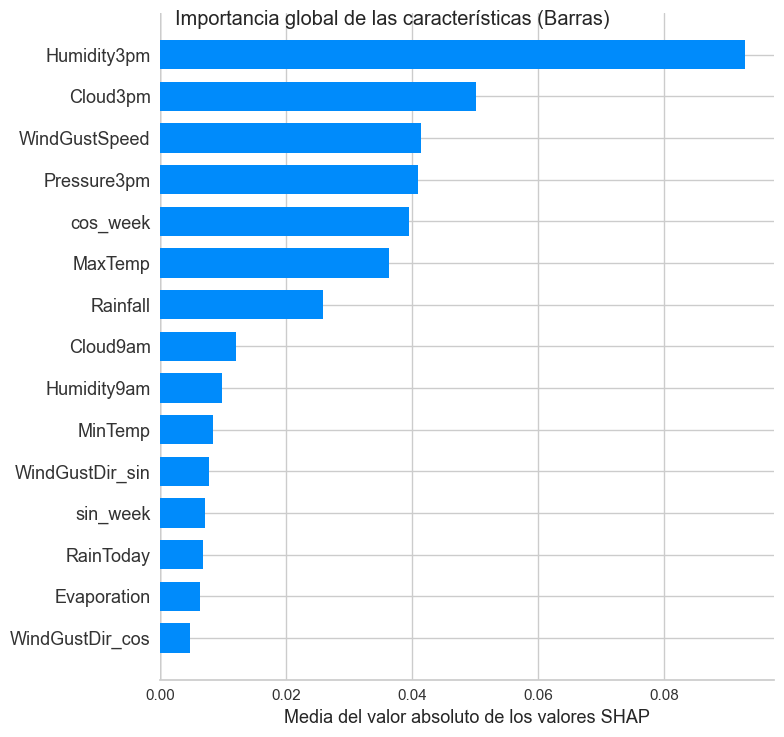

In [135]:
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False,feature_names=X_test.columns.values)
plt.gcf().suptitle("Importancia global de las características (Barras)")
plt.gca().set_xlabel("Media del valor absoluto de los valores SHAP")
plt.show()

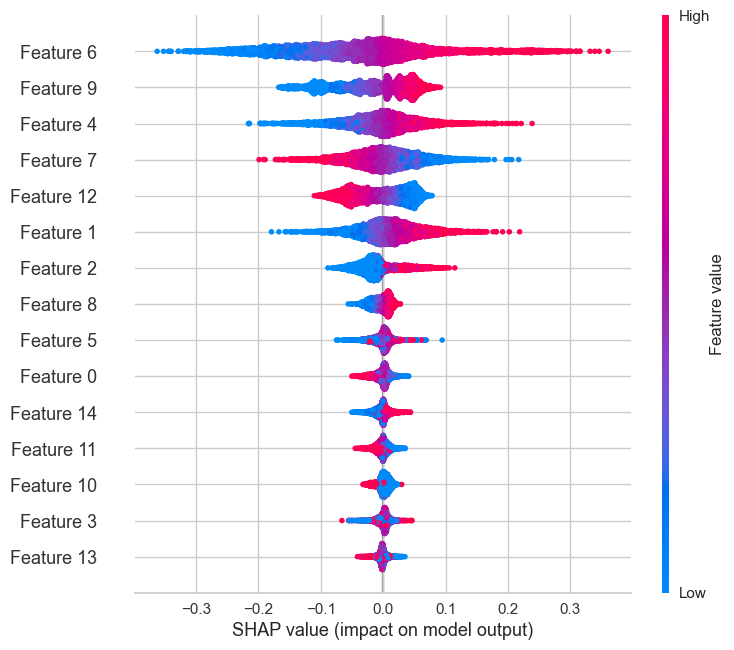

<Figure size 800x550 with 0 Axes>

In [136]:
feature_names=X_test.columns.values
shap.plots.beeswarm(shap_values ,max_display=len(X_test.columns))
plt.gcf().suptitle("Impacto global de las características (Beeswarm)")
plt.show()

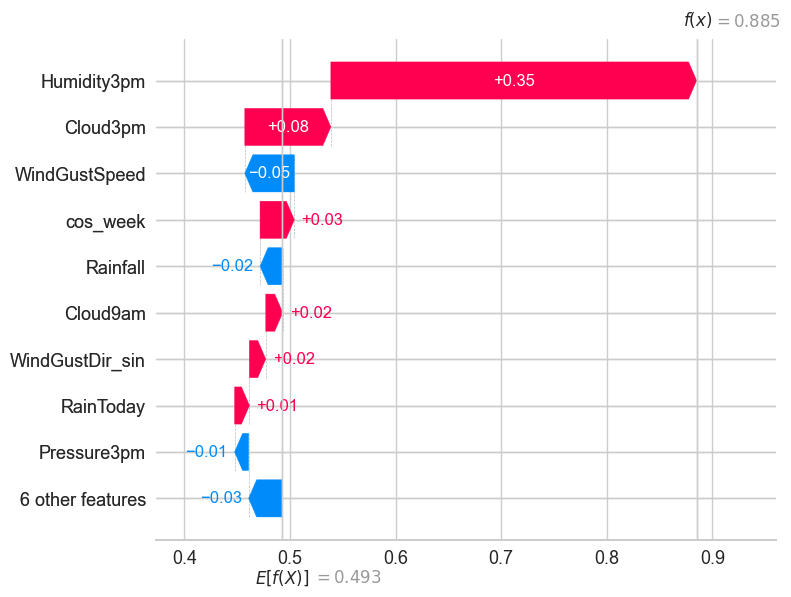

In [137]:
index=10

base_value = predict_function(X_train.values).mean() # Calculamos el valor base manualmente con la media

explanation = shap.Explanation(
    values=shap_values[index].values,
    base_values=base_value,
    feature_names=feature_names
)
shap.plots.waterfall(explanation)

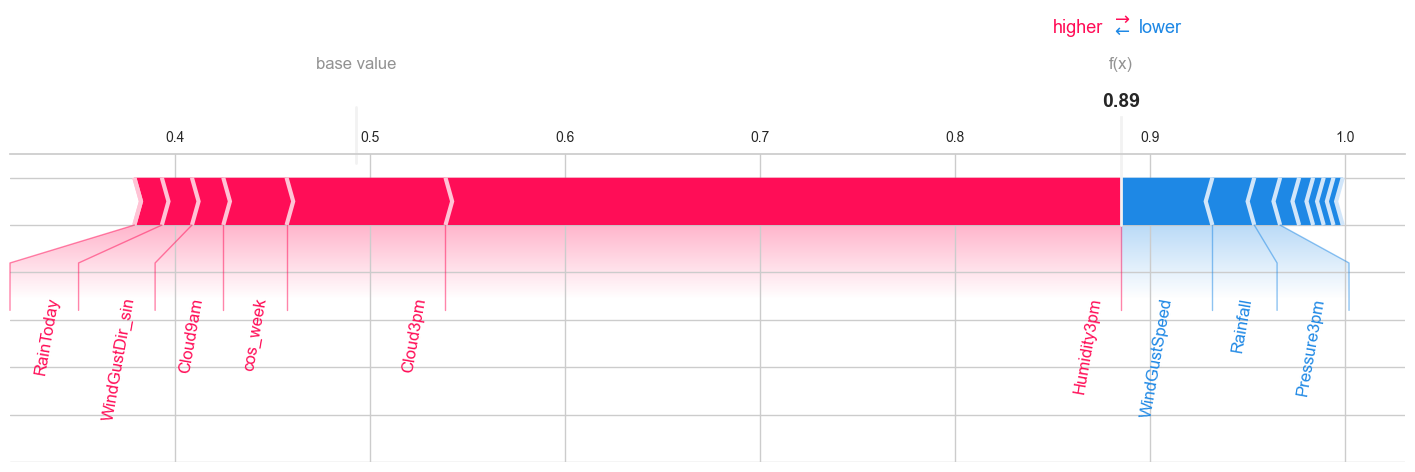

In [138]:
base_value = predict_function(X_train.values).mean() 

shap.force_plot(
    base_value,
    shap_values[index].values,  # Valores SHAP para la instancia seleccionada
    feature_names=feature_names,
    matplotlib=True, 
    figsize=(18, 4),
    text_rotation=80
)

In [139]:
X_test.iloc[index]

MinTemp            0.413474
MaxTemp           -0.708951
Rainfall          -0.319143
Evaporation       -0.395939
WindGustSpeed     -1.888902
Humidity9am        0.628577
Humidity3pm        2.013827
Pressure3pm        0.594833
Cloud9am           1.000000
Cloud3pm           1.000000
RainToday          0.000000
sin_week           0.947326
cos_week          -0.320270
WindGustDir_cos    0.382683
WindGustDir_sin    0.923880
Name: 2239, dtype: float64

In [140]:
df.iloc[index]

Date               2008-12-11 00:00:00
Location                        Albury
MinTemp                           13.4
MaxTemp                           30.4
Rainfall                           0.0
Evaporation                        NaN
Sunshine                           NaN
WindGustDir                        0.0
WindGustSpeed                     30.0
WindDir9am                         SSE
WindDir3pm                         ESE
WindSpeed9am                      17.0
WindSpeed3pm                       6.0
Humidity9am                       48.0
Humidity3pm                       22.0
Pressure9am                     1011.8
Pressure3pm                     1008.7
Cloud9am                           NaN
Cloud3pm                           NaN
Temp9am                           20.4
Temp3pm                           28.8
RainToday                            0
RainTomorrow                         1
sin_week                     -0.348202
cos_week                       0.93742
WindGustDir_cos          

Calculamos manualmente el expected_value como el promedio de las predicciones del conjunto de entrenamiento

Se puede ver que la variable "Humidity3pm" fue de gran influencia en la predicción

## Conclusión

A lo largo del desarrollo de este trabajo práctico nos interiorizamos en el dataset, pudiendo crear codificaciones y transformaciones adecuadas para las variables, lo que llevó iterativamente a mejorar el desempeño tanto de la regresión logística como el de redes neuronales. Estas últimas pudieron aprovechar los recursos que las codificaciones trigonométricas nos brindaron, a pesar de conllevar un costo computacional más grande.

Para el deployment por fines didácticos decidimos implementar la red neuronal a pesar de que creemos que es más eficiente usar regresión por su interpretabilidad y rápida inferencia.

Como mejorías futuras podríamos utilizar técnicas de exploración más avanzadas para encontrar ratios o relaciones aún no descubiertas entre las variables que podría ayudarnos a simplificar el modelo de red neuronal o a mejorar la performance de la regresión, es decir, alocar más tiempo a feature engineering con el fin de conocimiento más profundo del dataset.

En términos de métricas, la mayoría de los modelos se encontraron muy cerca unos de otros.

Este trabajo nos permitió comprender la importancia del preprocesamiento de datos y la selección adecuada del modelo según el contexto de aplicación. Si bien las redes neuronales mostraron un rendimiento ligeramente superior, la regresión logística demostró ser una alternativa robusta y más eficiente en términos de recursos. Esta experiencia nos brindó valiosas lecciones sobre el balance entre complejidad del modelo, interpretabilidad y rendimiento en problemas de predicción meteorológica.